In [50]:
                                        ######################################################

            # After today's (third) report, we have decided to create different setups and optimize the lr in each one of them

                                        ######################################################

In [51]:
import torch
import numpy as np
from qibo import Circuit, gates
import matplotlib.pyplot as plt

In [52]:
# ----------- Quantum circuit builder -----------
def build_circuit(x_input, theta):
    circuit = Circuit(1)
    
    # Prepare input state
    if x_input == 1:  # |+⟩ = H|0⟩
        circuit.add(gates.H(0))
    else:
        pass  # |0⟩ is already default
    # Trainable rotation
    circuit.add(gates.RY(0, theta))

    # Measure
    circuit.add(gates.M(0))
    
    return circuit
    

# ----------- Parameter-shift gradient estimator -----------
def parameter_shift_grad(x_input, theta, label, shift=np.pi/2, n_shots=1):
    theta_plus = theta + shift
    theta_minus = theta - shift

    # Evaluate circuit at shifted parameters
    result_plus = build_circuit(x_input, theta_plus)(nshots=n_shots)
    result_minus = build_circuit(x_input, theta_minus)(nshots=n_shots)


    #bit_plus = int(result_plus.samples()[0, 0])
    bit_plus = np.mean(result_plus.samples())
    #print("Number of Shots:", n_shots)
    #bit_minus = int(result_minus.samples()[0, 0])
    bit_minus = np.mean(result_minus.samples())

    pred_plus = bit_plus
    pred_minus = bit_minus

    """# Loss = 0 if prediction == label, 1 otherwise
    loss_plus = 0.0 if pred_plus == label else 1.0
    loss_minus = 0.0 if pred_minus == label else 1.0"""
    # Clip to avoid log(0)
    eps = 1e-6
    p_plus = np.clip(pred_plus, eps, 1 - eps)
    p_minus = np.clip(pred_minus, eps, 1 - eps)

    # BCE loss
    loss_plus = -label * np.log(p_plus) - (1 - label) * np.log(1 - p_plus)
    loss_minus = -label * np.log(p_minus) - (1 - label) * np.log(1 - p_minus)

    grad = 0.5 * (loss_plus - loss_minus)
    return grad


# ----------- Simple Training Loop (PyTorch Optimizer) -----------
class QuantumModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        init_param = np.round(np.random.uniform(0, 2*np.pi), 5)
        self.theta = torch.nn.Parameter(torch.tensor([init_param], dtype=torch.float32))

    def forward(self, x_input):
        circuit = build_circuit(x_input, self.theta.item())
        return circuit

In [53]:
class Client:
    def __init__(self, num_samples, seed, vqc_class=QuantumModel, sigma=0, target_class0_ratio=None, n_shots=1):
        
        self.num_samples = num_samples
        self.seed = seed       
        self.model = vqc_class()
        self.sigma = sigma
        self.target_class0_ratio = target_class0_ratio
        self.labels = self._generate_labels()
        self.sample_pointer = 0  
        self.local_weights_evolution = []
        self.n_shots = n_shots  # Number of shots for gradient calculation
        

    def _generate_labels(self):
        """
        Generate labels for this client with class imbalance based on sigma.
        """
        np.random.seed(self.seed)
        
        if self.target_class0_ratio is not None:
            num_class0 = int(round(self.num_samples * self.target_class0_ratio))
            num_class1 = self.num_samples - num_class0
            labels = np.array([0] * num_class0 + [1] * num_class1)
            np.random.shuffle(labels)
        else:
            raw_bias = np.random.normal(0, self.sigma)
            prob_class_0 = 1 / (1 + np.exp(-raw_bias))  # sigmoid
            labels = np.random.choice([0, 1], size=self.num_samples, p=[prob_class_0, 1 - prob_class_0])
    
        return labels
        

    def get_label_distribution(self):
        """
        Returns the proportion of class 0 and class 1.
        """
        prop_class_0 = np.mean(self.labels == 0)
        prop_class_1 = 1 - prop_class_0
        return {'class_0': prop_class_0, 'class_1': prop_class_1}
        

    def set_theta(self, new_theta):
        with torch.no_grad():
            self.model.theta.copy_(torch.tensor(new_theta, dtype=torch.float64))

    
    def get_theta(self):
        return self.model.theta.detach().numpy()


    # def compute_grad(self, x_input, theta, label, shift=np.pi/2):
    #     grad = parameter_shift_grad(x_input=x_input, theta=theta, label=label, shift=shift, n_shots=self.n_shots)
    #     return grad
            

    def local_train(self, batch_size, lr=0.1):

        # Select next batch
        start = self.sample_pointer
        end = min(start + batch_size, self.num_samples)
        self.sample_pointer = end
    
        if end - start == 0:
            return self.get_theta()  # No more data

        training_data = self.labels[start:end]
        theta_history = []
        grads = []
    
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        #optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        #loss_fn = nn.BCELoss()

        local_weights_evolution_aux = []
        
        for epoch, label in enumerate(training_data):
            #print("LABEL USED:", label)
            x_input = label
            optimizer.zero_grad()
        
            # Estimate gradient via parameter-shift
            grad_estimate = parameter_shift_grad(x_input, self.model.theta.item(), label, n_shots=self.n_shots)
            grads.append(grad_estimate)
            
            # Manually assign gradient to parameter
            self.model.theta.grad = torch.tensor([grad_estimate], dtype=torch.float32)
        
            optimizer.step()
        
            # Track accuracy and current value
            #prediction = self.model(x_input)
            #correct = (prediction == label)
            #theta_history.append(np.round(self.model.theta.item(), 4))
            #print(f"Epoch {epoch:03d} | x={x_input} | Label={label} | Pred={prediction} | θ={self.model.theta.item():.4f} | Correct={correct}")
            theta = self.get_theta().copy()
            #print("Updated parameters to:",theta[0])
            local_weights_evolution_aux.append(theta[0])
        self.local_weights_evolution.append(local_weights_evolution_aux)
    
        return self.get_theta()

In [54]:
def create_clients_setup(num_clients=5, num_samples=100, sigma_range=(0.0, 0.0), seed=0, vqc_class=QuantumModel, 
                         target_class0_ratio=None, n_shots=1):
    np.random.seed(seed)
    clients = []

    for i in range(num_clients):
        sigma = np.random.uniform(*sigma_range)
        client_seed = seed + i
        client = Client(sigma=sigma, 
                        num_samples=num_samples, 
                        seed=client_seed, 
                        vqc_class=vqc_class,
                        target_class0_ratio=target_class0_ratio,
                        n_shots=n_shots)
        clients.append(client)

    return clients

In [55]:
def compute_Psuccess(client):
    Ps0 = client.model(0)(nshots=None).probabilities()[0]
    Ps1 = client.model(1)(nshots=None).probabilities()[1]

    Psuc = 0.5 * (Ps0 + Ps1)
    return Psuc

In [56]:
def repeat_setup(lr_values, seeds, num_clients, num_samples, sigma_range, n_shots, target_class0_ratio=None):

    print(f" ---- SETUP Info ---- ")
    print(f" - Num Clients: {num_clients}")
    print(f" - Num Samples: {num_samples}")
    print(f" - Sigma: {sigma_range}")
    print(f" - Shots: {n_shots}")
    print(f" - lr: {lr_values}")

    all_mean_Psucs = []
    all_min_Psucs = []

    step_count = int(len(seeds) / 10)

    for seed in seeds:
        if seed%step_count==0:
            print(f"Seed #{seed}")
        mean_Psucs = []
        min_Psucs = []
        
        for lr in lr_values:
            Psucs = []
            clients = create_clients_setup(
                num_clients=num_clients,
                num_samples=num_samples,
                sigma_range=sigma_range,
                seed=seed,
                vqc_class=QuantumModel,
                target_class0_ratio=target_class0_ratio,
                n_shots=n_shots
            )

            for client in clients:
                client.local_train(client.num_samples, lr=lr)
                client_psuc = np.round(compute_Psuccess(client), 4)
                Psucs.append(client_psuc)
            
            mean_Psucs.append(np.mean(Psucs))
            min_Psucs.append(np.min(Psucs))
        
        all_mean_Psucs.append(mean_Psucs)
        all_min_Psucs.append(min_Psucs)

    return np.array(all_mean_Psucs), np.array(all_min_Psucs) 

In [57]:
def compute_optimal_lr(all_Psucs, lr_values, num_seeds):
      
    data_per_lr = all_Psucs.T  # (40, 3)
    data_list = [data_per_lr[i, :] for i in range(data_per_lr.shape[0])]
    
    plt.figure(figsize=(12, 6))
    
    # use integer positions instead of actual LR values for spacing
    positions = np.arange(len(lr_values))
    
    plt.boxplot(data_list, positions=positions, widths=0.6, patch_artist=True)
    
    # make x-ticks readable
    plt.xticks(
        positions[::2],  # show every 2nd tick
        [f"{lr:.2f}" for lr in lr_values[::2]], 
        rotation=45,
    )
    
    plt.xlabel("Learning rate")
    plt.ylabel("Mean Psuc")
    plt.title(f"Performance across {num_seeds} seeds for different learning rates")
    plt.grid(True, linestyle="--", alpha=0.5)
    
    # optional: overlay mean line
    means = data_per_lr.mean(axis=1)
    plt.plot(positions, means, color="red", marker="o", linewidth=2, label="Mean across seeds")
    plt.legend()
    
    plt.tight_layout()
    plt.show()


    # compute mean across seeds for each lr
    means = data_per_lr.mean(axis=1)
    
    # find best lr
    best_idx = np.argmax(means)
    best_lr = lr_values[best_idx]
    best_value = means[best_idx]
    
    print(f"Best learning rate: {best_lr:.2f} with mean Psuc = {best_value:.4f}")
 

    return np.round(best_lr, 2)

In [58]:
def visualize_label_dist(clients):
    # Collect label distributions from all clients
    distributions = [client.get_label_distribution() for client in clients]
    
    # Extract class names from the first client (assuming all clients have the same classes)
    classes = list(distributions[0].keys())
    n_clients = len(distributions)
    
    # Build a matrix of shape (n_clients, n_classes)
    matrix = np.array([[dist[c] for c in classes] for dist in distributions])

    fig, ax = plt.subplots(figsize=(12, 6))

    bottom = np.zeros(n_clients)
    for i, c in enumerate(classes):
        values = matrix[:, i]
        ax.bar(range(n_clients), values, bottom=bottom, label=c)
        bottom += values
    
    ax.set_xticks(range(n_clients))
    ax.set_xticklabels([f"Client {i}" for i in range(n_clients)], rotation=45)
    ax.set_ylabel("Proportion")
    ax.set_title("Stacked Label Distribution per Client")
    ax.legend()
    plt.tight_layout()
    plt.show()

In [59]:
# QFL functions

In [60]:
def average_angles_modulo(weights_list):
    angles = np.array(weights_list)
    x = np.cos(angles)
    y = np.sin(angles)

    mean_x = np.mean(x)
    mean_y = np.mean(y)

    mean_angle = np.arctan2(mean_y, mean_x)
    return mean_angle % (2 * np.pi)

In [61]:
def run_federated_training_ECAI(clients, num_rounds, lr, local_batch_size=5):
    
    global_weights_evolution = []
    for rnd in range(num_rounds):
        #print(f"\n--- Round {rnd+1} ---")

        # for client in clients:
        #     for param in client.model.parameters():
        #         print("CLIENT PARAM:", param)
        
        local_weights = []

        for client in clients:
            weights = client.local_train(batch_size=local_batch_size, lr=lr)
            local_weights.append(weights)

        # for client in clients:
        #     for param in client.model.parameters():
        #         print(param)

        # Federated averaging
        global_weights = average_angles_modulo(local_weights)
        global_weights_evolution.append(global_weights)
        # print(f"Local weights: {local_weights}, Average: {global_weights}")

        # Broadcast new weights
        for client in clients:
            client.set_theta(global_weights)

    return global_weights_evolution

In [62]:
def repeat_ECAI_QFL_setup(lr_values, seeds, num_clients, num_samples, sigma_range, n_shots, 
                          num_rounds, local_batch_size, target_class0_ratio=None):

    print(f" ---- SETUP Info ---- ")
    print(f" - Num Clients: {num_clients}")
    print(f" - Num Samples: {num_samples}")
    print(f" - Sigma: {sigma_range}")
    print(f" - Shots: {n_shots}")
    print(f" - Number of Rounds: {num_rounds}")
    print(f" - Local Batch: {local_batch_size}")
    print(f" - lr: {lr_values}")
    
    QFL_Psucs = []

    step_count = int(len(seeds) / 10)

    for seed in seeds:
        if seed%step_count==0:
            print(f"Seed #{seed}")
        QFL_Psucs_aux = []
        
        for lr in lr_values:
            clients = create_clients_setup(
                num_clients=num_clients,
                num_samples=num_samples,
                sigma_range=sigma_range,
                seed=seed,
                vqc_class=QuantumModel,
                target_class0_ratio=target_class0_ratio,
                n_shots=n_shots
            )

            global_weights_evolution = run_federated_training_ECAI(clients, num_rounds=num_rounds, lr=lr, 
                                                                   local_batch_size=local_batch_size)
            QFL_client = Client(None, None)
            QFL_client.set_theta(global_weights_evolution[-1])
            
            global_psuc = np.round(compute_Psuccess(QFL_client), 4)
            # for client in clients:
            #     client.local_train(client.num_samples, lr=lr)
            #     client_psuc = np.round(compute_Psuccess(client), 4)
            #     Psucs.append(client_psuc)
            
            QFL_Psucs_aux.append(global_psuc)
        
        QFL_Psucs.append(QFL_Psucs_aux)

    return np.array(QFL_Psucs) 

In [63]:
optimal_client = Client(None, None)
optimal_client.set_theta(np.pi/4)
compute_Psuccess(optimal_client)

np.float64(0.8535533905932735)

# Setup 3 ---- 5 samples, 10 clients

In [64]:
num_clients = 10
num_samples = 5

## σ=0.0

In [65]:
sigma_range = (0.0, 0.0)

### Single client 1 shot

In [66]:
n_shots = 1

In [67]:
# SETUP PARAMETER

lr_values = np.arange(0.30, 0.80, 0.01)
seeds = np.arange(0, 100)

In [68]:
all_mean_Psucs, all_min_Psucs = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 5
 - Sigma: (0.0, 0.0)
 - Shots: 1
 - lr: [0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41 0.42 0.43
 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55 0.56 0.57
 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69 0.7  0.71
 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


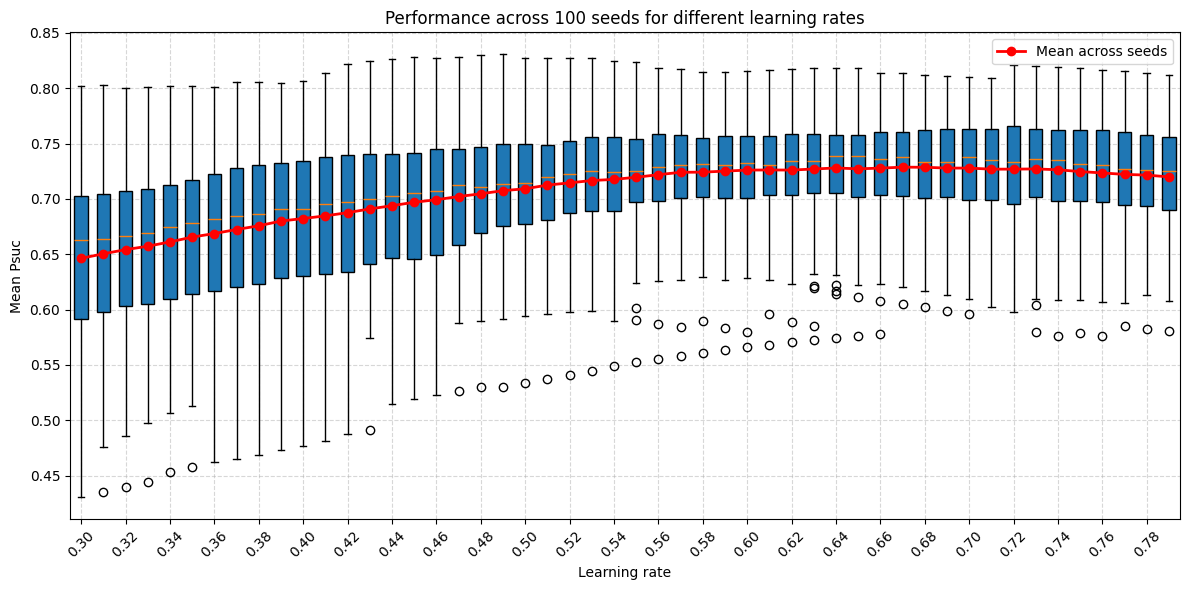

Best learning rate: 0.67 with mean Psuc = 0.7286


In [69]:
opt_lr_1s_s0 = compute_optimal_lr(all_mean_Psucs, lr_values=lr_values, num_seeds=len(seeds))

In [70]:
### Let's try the optimal lr in a few exps!

In [71]:
# SETUP PARAMETER

lr_values = [opt_lr_1s_s0]
seeds = np.arange(0, 100)

In [72]:
all_mean_Psucs_1s_s0, all_min_Psucs_1s_s0 = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 5
 - Sigma: (0.0, 0.0)
 - Shots: 1
 - lr: [np.float64(0.67)]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


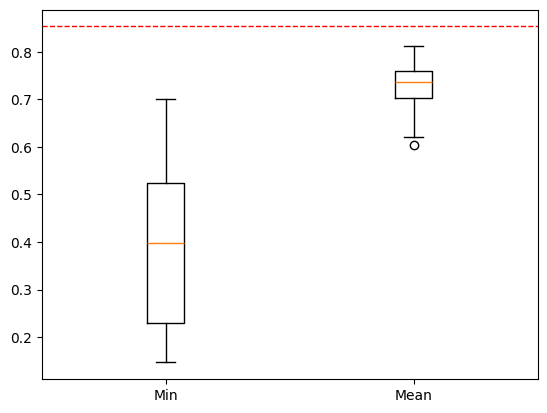

In [73]:
plt.boxplot([all_min_Psucs_1s_s0.flatten(), all_mean_Psucs_1s_s0.flatten()], tick_labels=["Min", "Mean"])
plt.axhline(y=0.8536, color='r', linestyle='--', linewidth=1)
plt.show()

### Single client ¡10 shots!

In [74]:
n_shots = 10

In [75]:
# SETUP PARAMETER

lr_values = np.arange(0.30, 0.80, 0.01)
seeds = np.arange(0, 100)

In [76]:
all_mean_Psucs, all_min_Psucs = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 5
 - Sigma: (0.0, 0.0)
 - Shots: 10
 - lr: [0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41 0.42 0.43
 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55 0.56 0.57
 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69 0.7  0.71
 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


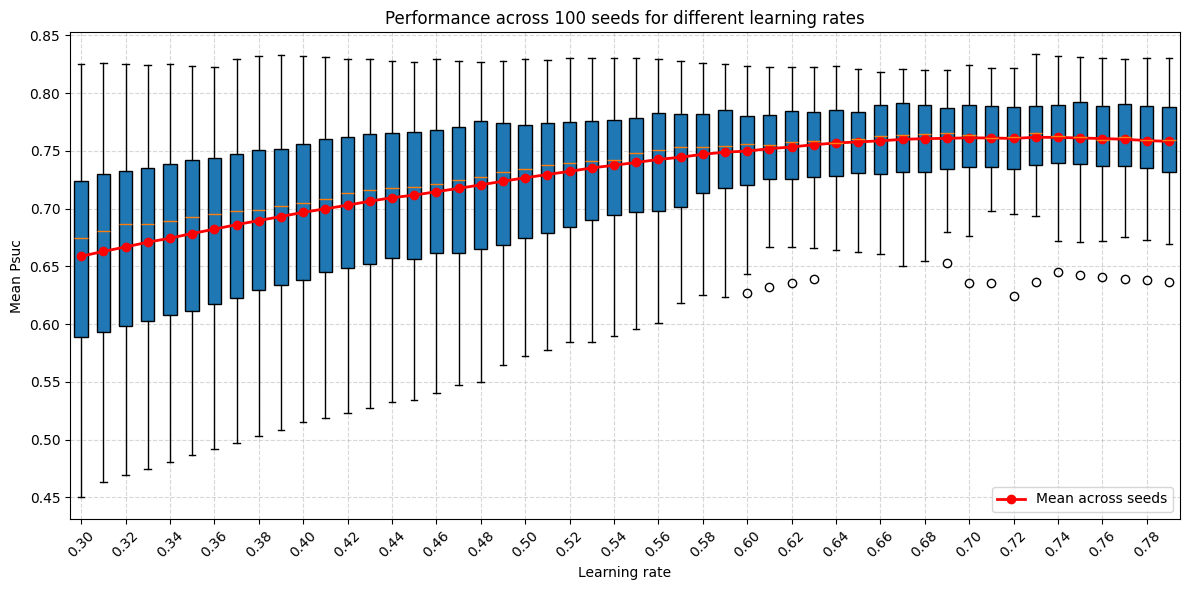

Best learning rate: 0.73 with mean Psuc = 0.7618


In [77]:
opt_lr_10s_s0 = compute_optimal_lr(all_mean_Psucs, lr_values=lr_values, num_seeds=len(seeds))

In [78]:
# SETUP PARAMETER

lr_values = [opt_lr_10s_s0]
seeds = np.arange(0, 100)

In [79]:
all_mean_Psucs_10s_s0, all_min_Psucs_10s_s0 = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 5
 - Sigma: (0.0, 0.0)
 - Shots: 10
 - lr: [np.float64(0.73)]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


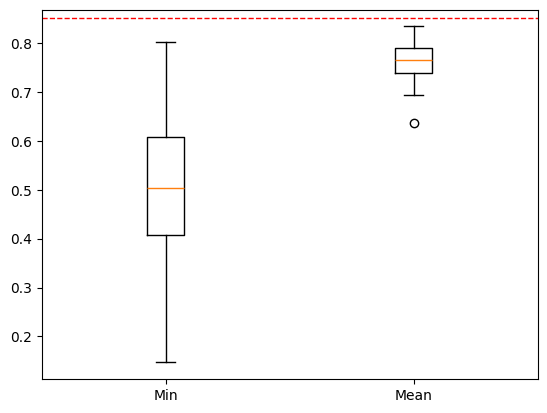

In [80]:
plt.boxplot([all_min_Psucs_10s_s0.flatten(), all_mean_Psucs_10s_s0.flatten()], tick_labels=["Min", "Mean"])
plt.axhline(y=0.85, color='r', linestyle='--', linewidth=1)
plt.show()

### Single client ¡100 shots!

In [81]:
n_shots = 100

In [82]:
# SETUP PARAMETER

lr_values = np.arange(0.30, 0.80, 0.01)
seeds = np.arange(0, 100)

In [83]:
all_mean_Psucs, all_min_Psucs = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 5
 - Sigma: (0.0, 0.0)
 - Shots: 100
 - lr: [0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41 0.42 0.43
 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55 0.56 0.57
 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69 0.7  0.71
 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


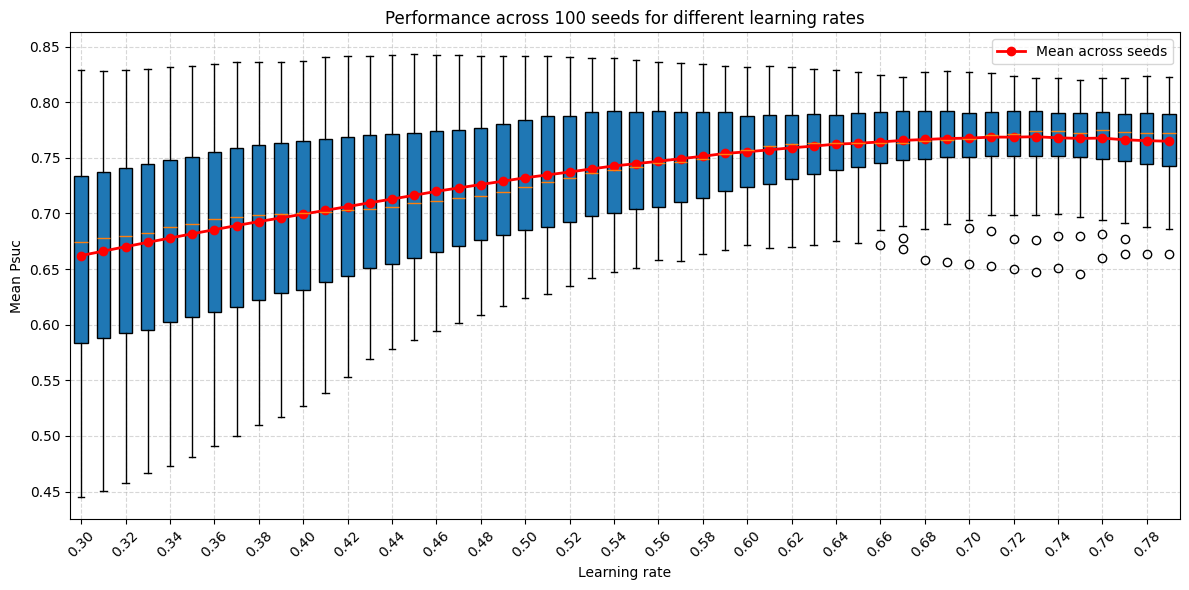

Best learning rate: 0.73 with mean Psuc = 0.7690


In [84]:
opt_lr_100s_s0 = compute_optimal_lr(all_mean_Psucs, lr_values=lr_values, num_seeds=len(seeds))

In [85]:
# SETUP PARAMETER

lr_values = [opt_lr_100s_s0]
seeds = np.arange(0, 100)

In [86]:
all_mean_Psucs_100s_s0, all_min_Psucs_100s_s0 = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 5
 - Sigma: (0.0, 0.0)
 - Shots: 100
 - lr: [np.float64(0.73)]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


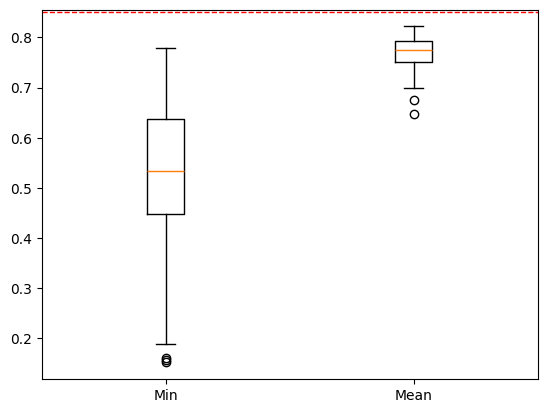

In [87]:
plt.boxplot([all_min_Psucs_100s_s0.flatten(), all_mean_Psucs_100s_s0.flatten()], tick_labels=["Min", "Mean"])
plt.axhline(y=0.85, color='r', linestyle='--', linewidth=1)
plt.show()

### QFL - 1 round with 5 local updates

In [88]:
# SETUP PARAMETER
num_rounds = 1
local_batch_size = 5
n_shots = 1

lr_values = np.arange(0.3, 1.3, 0.01)
seeds = np.arange(0, 100)

In [89]:
QFL_Psucs = repeat_ECAI_QFL_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots,
    num_rounds = num_rounds,
    local_batch_size = local_batch_size
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 5
 - Sigma: (0.0, 0.0)
 - Shots: 1
 - Number of Rounds: 1
 - Local Batch: 5
 - lr: [0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41 0.42 0.43
 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55 0.56 0.57
 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69 0.7  0.71
 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83 0.84 0.85
 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97 0.98 0.99
 1.   1.01 1.02 1.03 1.04 1.05 1.06 1.07 1.08 1.09 1.1  1.11 1.12 1.13
 1.14 1.15 1.16 1.17 1.18 1.19 1.2  1.21 1.22 1.23 1.24 1.25 1.26 1.27
 1.28 1.29]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


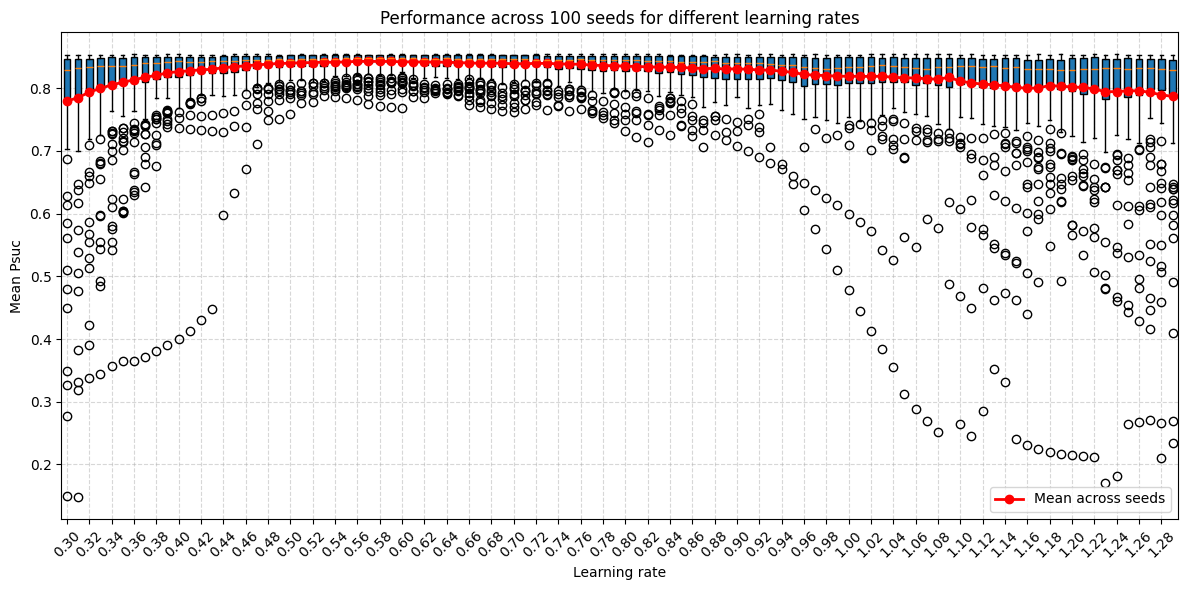

Best learning rate: 0.57 with mean Psuc = 0.8426


In [90]:
opt_lr_qfl_s0 = compute_optimal_lr(QFL_Psucs, lr_values=lr_values, num_seeds=len(seeds))

In [91]:
# SETUP PARAMETER
num_rounds = 1
local_batch_size = 5

lr_values = [opt_lr_qfl_s0]
seeds = np.arange(0, 100)

n_shots = 1

In [92]:
QFL_Psucs_s0 = repeat_ECAI_QFL_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots,
    num_rounds = num_rounds,
    local_batch_size = local_batch_size
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 5
 - Sigma: (0.0, 0.0)
 - Shots: 1
 - Number of Rounds: 1
 - Local Batch: 5
 - lr: [np.float64(0.57)]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


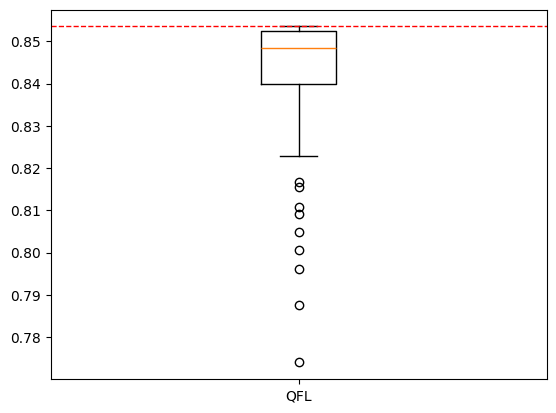

In [93]:
plt.boxplot([QFL_Psucs_s0.flatten()], tick_labels=["QFL"])
plt.axhline(y=0.8536, color='r', linestyle='--', linewidth=1)
plt.show()

### Comparisons

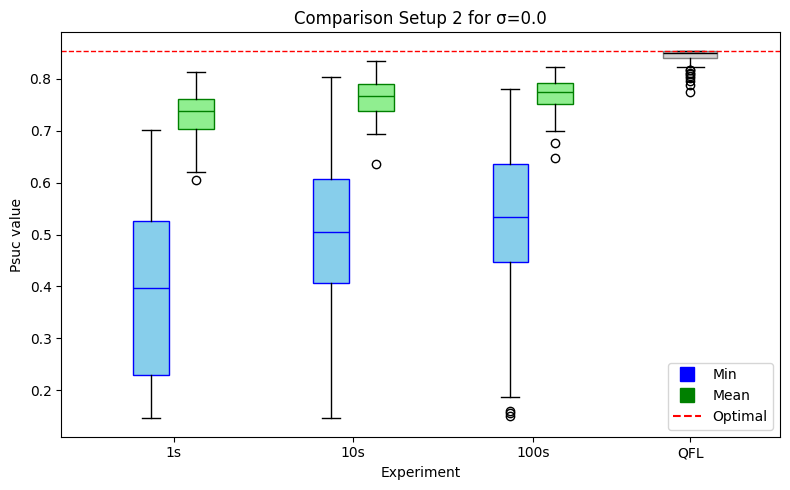

In [94]:
# Your data
min_setup1 = [all_min_Psucs_1s_s0.flatten(),
              all_min_Psucs_10s_s0.flatten(),
              all_min_Psucs_100s_s0.flatten()]

mean_setup1 = [all_mean_Psucs_1s_s0.flatten(),
               all_mean_Psucs_10s_s0.flatten(),
               all_mean_Psucs_100s_s0.flatten()]

QFL = QFL_Psucs_s0.flatten()

# Define positions
positions_min = [1, 2, 3]
positions_mean = [p + 0.25 for p in positions_min]
position_QFL = [4]

plt.figure(figsize=(8, 5))

# Box colors
boxprops_min = dict(facecolor='skyblue', color='blue')
boxprops_mean = dict(facecolor='lightgreen', color='green')
boxprops_qfl = dict(facecolor='lightgray', color='gray')

# Plot boxplots
plt.boxplot(min_setup1, positions=positions_min, widths=0.2, patch_artist=True,
            boxprops=boxprops_min, medianprops=dict(color='blue'))
plt.boxplot(mean_setup1, positions=positions_mean, widths=0.2, patch_artist=True,
            boxprops=boxprops_mean, medianprops=dict(color='green'))
plt.boxplot([QFL], positions=position_QFL, widths=0.3, patch_artist=True,
            boxprops=boxprops_qfl, medianprops=dict(color='black'))

# Reference line
plt.axhline(y=0.8536, color='r', linestyle='--', linewidth=1, label="Reference (0.8536)")

# X-axis labels
xticks = [p + 0.125 for p in positions_min] + position_QFL
xticklabels = ["1s", "10s", "100s", "QFL"]
plt.xticks(xticks, xticklabels)

plt.xlabel("Experiment")
plt.ylabel("Psuc value")
plt.title(f"Comparison Setup 2 for σ={sigma_range[0]}")

# Legend — only Min, Mean, and Reference
handles = [
    plt.Line2D([], [], color='blue', marker='s', markersize=10, linestyle='None', label='Min'),
    plt.Line2D([], [], color='green', marker='s', markersize=10, linestyle='None', label='Mean'),
    plt.Line2D([], [], color='red', linestyle='--', label='Optimal')
]
plt.legend(handles=handles, loc='best')

plt.tight_layout()
plt.show()


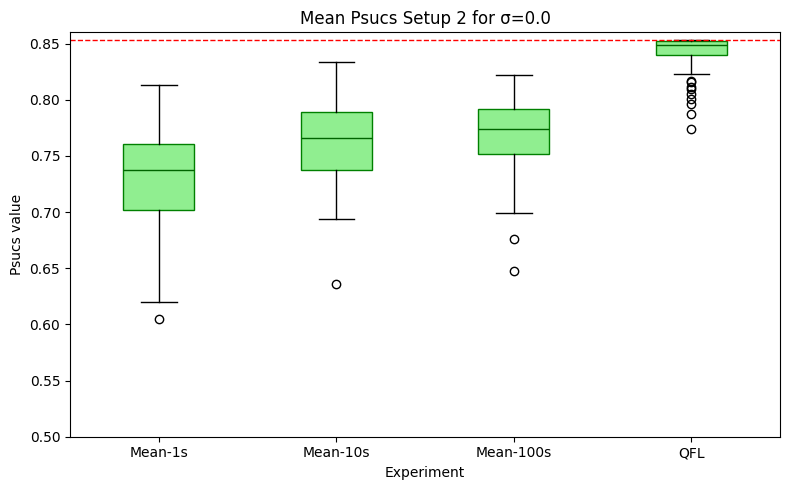

In [95]:
# Your data (mean only)
mean_setup1 = [all_mean_Psucs_1s_s0.flatten(),
               all_mean_Psucs_10s_s0.flatten(),
               all_mean_Psucs_100s_s0.flatten(),
               QFL_Psucs_s0.flatten()]

# Create figure
plt.figure(figsize=(8, 5))

# Box color settings
boxprops_mean = dict(facecolor='lightgreen', color='green')

# Plot boxplot
plt.boxplot(mean_setup1, tick_labels=["Mean-1s", "Mean-10s", "Mean-100s", "QFL"],
            widths=0.4, patch_artist=True,
            boxprops=boxprops_mean, medianprops=dict(color='darkgreen'))

# Reference line
plt.axhline(y=0.8536, color='r', linestyle='--', linewidth=1)

# Labels and title
plt.xlabel("Experiment")
plt.ylabel("Psucs value")
plt.title(f"Mean Psucs Setup 2 for σ={sigma_range[0]}")

# Optionally zoom in on higher range (adjust as needed)
plt.ylim(0.5, 0.86)  # <-- Adjust this range depending on your data

plt.tight_layout()
plt.show()


In [96]:
print(np.mean(all_min_Psucs_1s_s0))
print(np.mean(all_min_Psucs_10s_s0))
print(np.mean(all_min_Psucs_100s_s0))
print(np.mean(QFL_Psucs_s0))

0.38500499999999993
0.508131
0.528072
0.84258


In [97]:
print(np.mean(all_mean_Psucs_1s_s0))
print(np.mean(all_mean_Psucs_10s_s0))
print(np.mean(all_mean_Psucs_100s_s0))
print(np.mean(QFL_Psucs_s0))

0.728636
0.7618320999999999
0.7690252000000001
0.84258


In [98]:
print(np.max(all_mean_Psucs_100s_s0))
print(np.max(QFL_Psucs_s0))

0.82182
0.8535


## σ=0.5

In [99]:
sigma_range = (0.5, 0.5)

### Single client 1 shot

In [100]:
n_shots = 1

In [101]:
# SETUP PARAMETER

lr_values = np.arange(0.30, 0.80, 0.01)
seeds = np.arange(0, 100)

In [102]:
all_mean_Psucs, all_min_Psucs = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 5
 - Sigma: (0.5, 0.5)
 - Shots: 1
 - lr: [0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41 0.42 0.43
 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55 0.56 0.57
 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69 0.7  0.71
 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


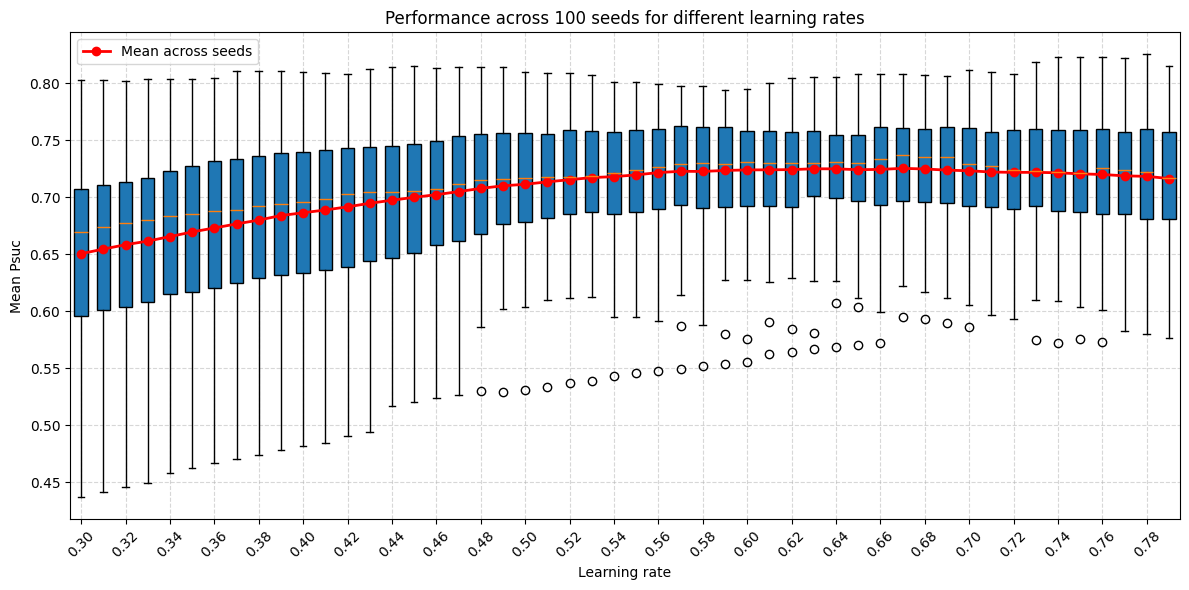

Best learning rate: 0.67 with mean Psuc = 0.7253


In [103]:
opt_lr_1s_s05 = compute_optimal_lr(all_mean_Psucs, lr_values=lr_values, num_seeds=len(seeds))

In [104]:
### Let's try the optimal lr in a few exps!

In [105]:
# SETUP PARAMETER

lr_values = [opt_lr_1s_s05]
seeds = np.arange(0, 100)

In [106]:
all_mean_Psucs_1s_s05, all_min_Psucs_1s_s05 = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 5
 - Sigma: (0.5, 0.5)
 - Shots: 1
 - lr: [np.float64(0.67)]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


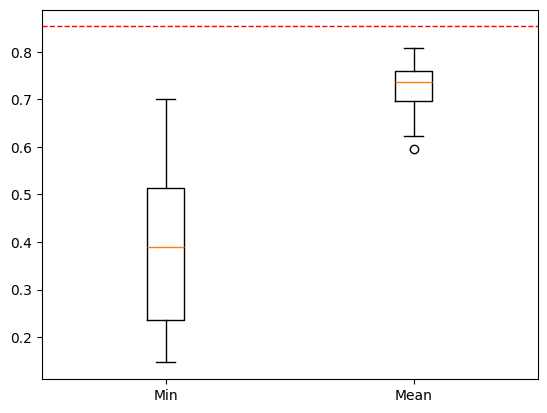

In [107]:
plt.boxplot([all_min_Psucs_1s_s05.flatten(), all_mean_Psucs_1s_s05.flatten()], tick_labels=["Min", "Mean"])
plt.axhline(y=0.8536, color='r', linestyle='--', linewidth=1)
plt.show()

### Single client ¡10 shots!

In [108]:
n_shots = 10

In [109]:
# SETUP PARAMETER

lr_values = np.arange(0.30, 0.80, 0.01)
seeds = np.arange(0, 100)

In [110]:
all_mean_Psucs, all_min_Psucs = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 5
 - Sigma: (0.5, 0.5)
 - Shots: 10
 - lr: [0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41 0.42 0.43
 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55 0.56 0.57
 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69 0.7  0.71
 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


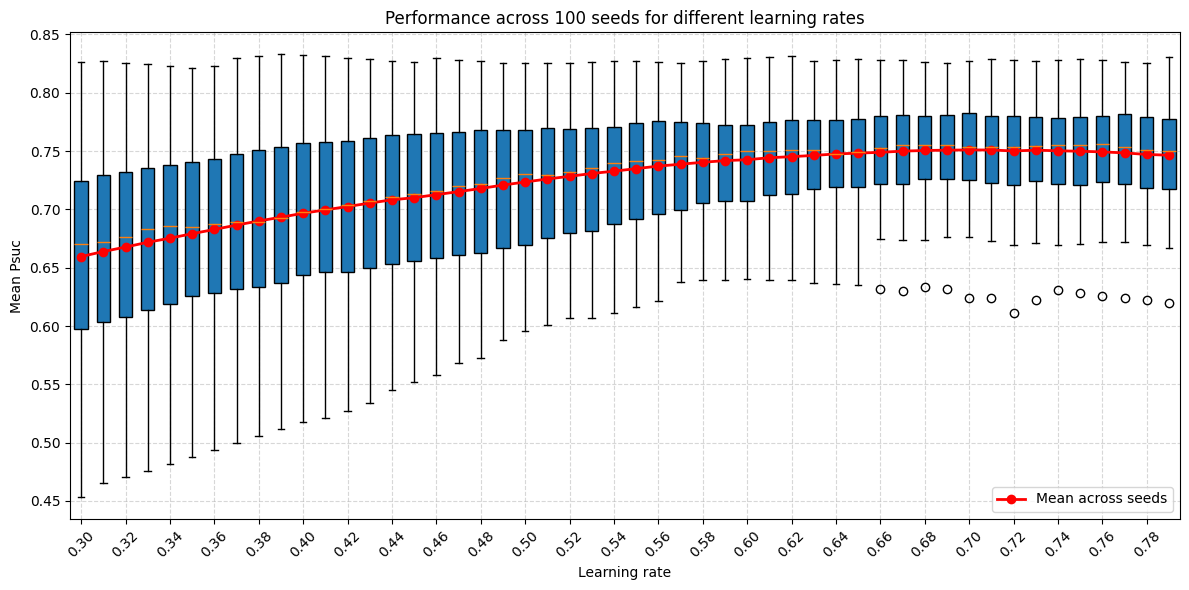

Best learning rate: 0.70 with mean Psuc = 0.7510


In [111]:
opt_lr_10s_s05 = compute_optimal_lr(all_mean_Psucs, lr_values=lr_values, num_seeds=len(seeds))

In [112]:
# SETUP PARAMETER

lr_values = [opt_lr_10s_s05]
seeds = np.arange(0, 100)

In [113]:
all_mean_Psucs_10s_s05, all_min_Psucs_10s_s05 = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 5
 - Sigma: (0.5, 0.5)
 - Shots: 10
 - lr: [np.float64(0.7)]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


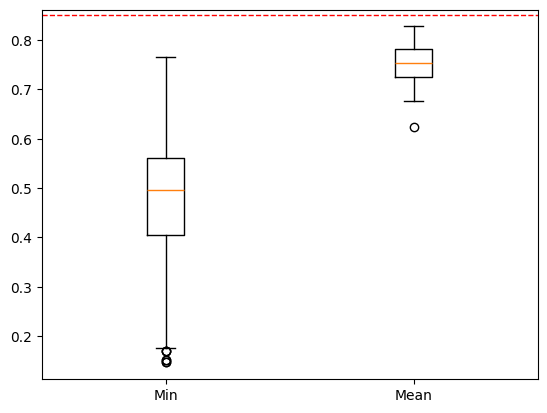

In [114]:
plt.boxplot([all_min_Psucs_10s_s05.flatten(), all_mean_Psucs_10s_s05.flatten()], tick_labels=["Min", "Mean"])
plt.axhline(y=0.85, color='r', linestyle='--', linewidth=1)
plt.show()

### Single client ¡100 shots!

In [115]:
n_shots = 100

In [116]:
# SETUP PARAMETER

lr_values = np.arange(0.30, 0.80, 0.01)
seeds = np.arange(0, 100)

In [117]:
all_mean_Psucs, all_min_Psucs = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 5
 - Sigma: (0.5, 0.5)
 - Shots: 100
 - lr: [0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41 0.42 0.43
 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55 0.56 0.57
 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69 0.7  0.71
 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


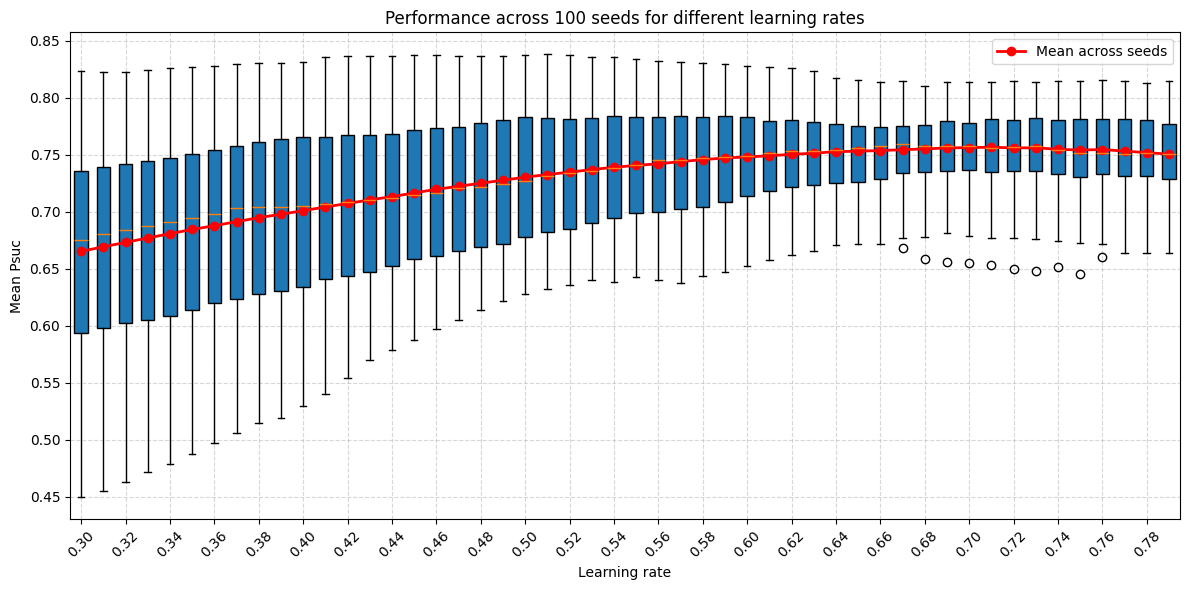

Best learning rate: 0.71 with mean Psuc = 0.7564


In [118]:
opt_lr_100s_s05 = compute_optimal_lr(all_mean_Psucs, lr_values=lr_values, num_seeds=len(seeds))

In [119]:
# SETUP PARAMETER

lr_values = [opt_lr_100s_s05]
seeds = np.arange(0, 100)

In [120]:
all_mean_Psucs_100s_s05, all_min_Psucs_100s_s05 = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 5
 - Sigma: (0.5, 0.5)
 - Shots: 100
 - lr: [np.float64(0.71)]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


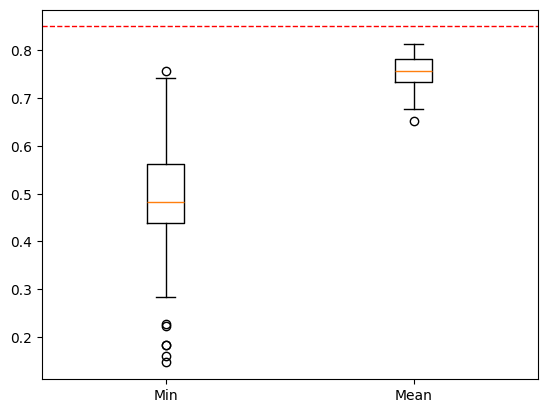

In [121]:
plt.boxplot([all_min_Psucs_100s_s05.flatten(), all_mean_Psucs_100s_s05.flatten()], tick_labels=["Min", "Mean"])
plt.axhline(y=0.85, color='r', linestyle='--', linewidth=1)
plt.show()

### QFL - 1 round with 5 local updates

In [122]:
# SETUP PARAMETER
num_rounds = 1
local_batch_size = 5
n_shots = 1

lr_values = np.arange(0.1, 1.1, 0.01)
seeds = np.arange(0, 100)

In [123]:
QFL_Psucs = repeat_ECAI_QFL_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots,
    num_rounds = num_rounds,
    local_batch_size = local_batch_size
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 5
 - Sigma: (0.5, 0.5)
 - Shots: 1
 - Number of Rounds: 1
 - Local Batch: 5
 - lr: [0.1  0.11 0.12 0.13 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23
 0.24 0.25 0.26 0.27 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37
 0.38 0.39 0.4  0.41 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51
 0.52 0.53 0.54 0.55 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65
 0.66 0.67 0.68 0.69 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79
 0.8  0.81 0.82 0.83 0.84 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93
 0.94 0.95 0.96 0.97 0.98 0.99 1.   1.01 1.02 1.03 1.04 1.05 1.06 1.07
 1.08 1.09]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


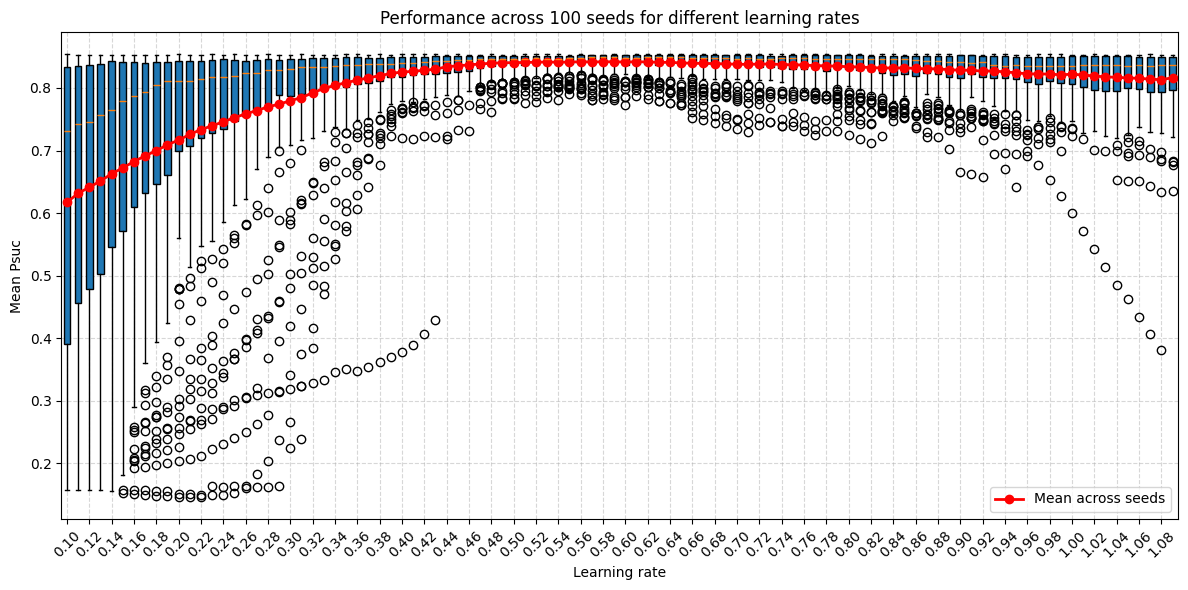

Best learning rate: 0.61 with mean Psuc = 0.8420


In [124]:
opt_lr_qfl_s05 = compute_optimal_lr(QFL_Psucs, lr_values=lr_values, num_seeds=len(seeds))

In [125]:
# SETUP PARAMETER
num_rounds = 1
local_batch_size = 5

lr_values = [opt_lr_qfl_s05]
seeds = np.arange(0, 100)

n_shots = 1

In [126]:
QFL_Psucs_s05 = repeat_ECAI_QFL_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots,
    num_rounds = num_rounds,
    local_batch_size = local_batch_size
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 5
 - Sigma: (0.5, 0.5)
 - Shots: 1
 - Number of Rounds: 1
 - Local Batch: 5
 - lr: [np.float64(0.61)]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


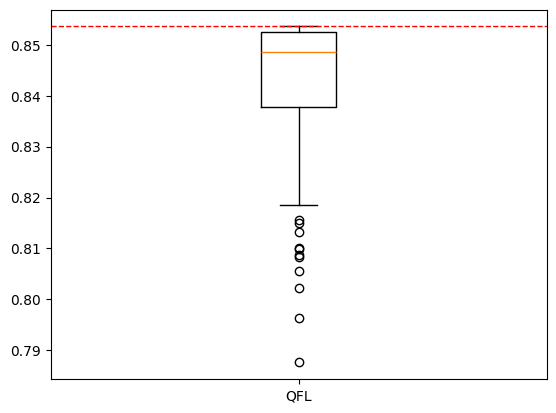

In [127]:
plt.boxplot([QFL_Psucs_s05.flatten()], tick_labels=["QFL"])
plt.axhline(y=0.8536, color='r', linestyle='--', linewidth=1)
plt.show()

### Comparisons

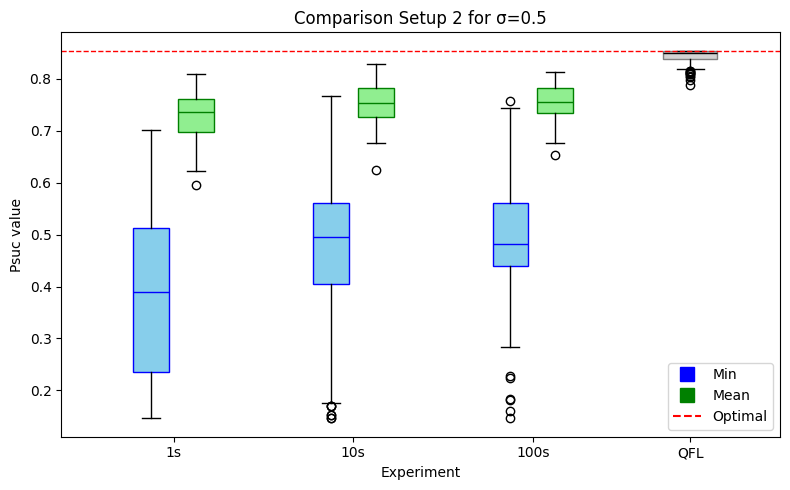

In [128]:
# Your data
min_setup1 = [all_min_Psucs_1s_s05.flatten(),
              all_min_Psucs_10s_s05.flatten(),
              all_min_Psucs_100s_s05.flatten()]

mean_setup1 = [all_mean_Psucs_1s_s05.flatten(),
               all_mean_Psucs_10s_s05.flatten(),
               all_mean_Psucs_100s_s05.flatten()]

QFL = QFL_Psucs_s05.flatten()

# Define positions
positions_min = [1, 2, 3]
positions_mean = [p + 0.25 for p in positions_min]
position_QFL = [4]

plt.figure(figsize=(8, 5))

# Box colors
boxprops_min = dict(facecolor='skyblue', color='blue')
boxprops_mean = dict(facecolor='lightgreen', color='green')
boxprops_qfl = dict(facecolor='lightgray', color='gray')

# Plot boxplots
plt.boxplot(min_setup1, positions=positions_min, widths=0.2, patch_artist=True,
            boxprops=boxprops_min, medianprops=dict(color='blue'))
plt.boxplot(mean_setup1, positions=positions_mean, widths=0.2, patch_artist=True,
            boxprops=boxprops_mean, medianprops=dict(color='green'))
plt.boxplot([QFL], positions=position_QFL, widths=0.3, patch_artist=True,
            boxprops=boxprops_qfl, medianprops=dict(color='black'))

# Reference line
plt.axhline(y=0.8536, color='r', linestyle='--', linewidth=1, label="Reference (0.8536)")

# X-axis labels
xticks = [p + 0.125 for p in positions_min] + position_QFL
xticklabels = ["1s", "10s", "100s", "QFL"]
plt.xticks(xticks, xticklabels)

plt.xlabel("Experiment")
plt.ylabel("Psuc value")
plt.title(f"Comparison Setup 2 for σ={sigma_range[0]}")

# Legend — only Min, Mean, and Reference
handles = [
    plt.Line2D([], [], color='blue', marker='s', markersize=10, linestyle='None', label='Min'),
    plt.Line2D([], [], color='green', marker='s', markersize=10, linestyle='None', label='Mean'),
    plt.Line2D([], [], color='red', linestyle='--', label='Optimal')
]
plt.legend(handles=handles, loc='best')

plt.tight_layout()
plt.show()


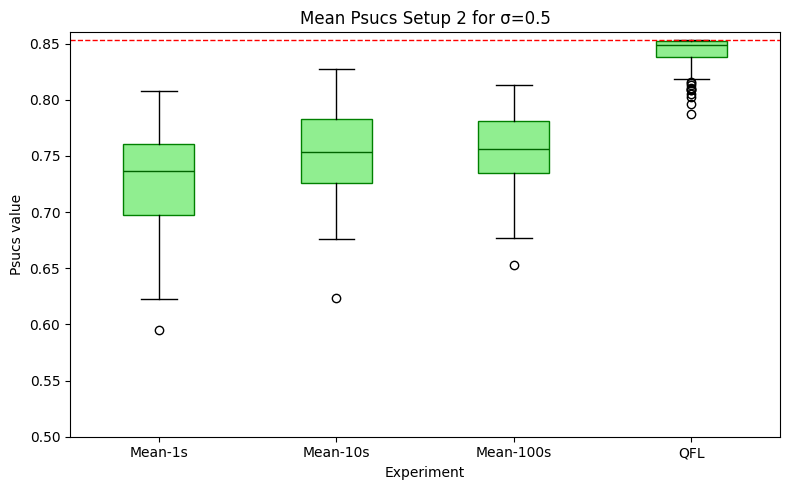

In [129]:
# Your data (mean only)
mean_setup1 = [all_mean_Psucs_1s_s05.flatten(),
               all_mean_Psucs_10s_s05.flatten(),
               all_mean_Psucs_100s_s05.flatten(),
               QFL_Psucs_s05.flatten()]

# Create figure
plt.figure(figsize=(8, 5))

# Box color settings
boxprops_mean = dict(facecolor='lightgreen', color='green')

# Plot boxplot
plt.boxplot(mean_setup1, tick_labels=["Mean-1s", "Mean-10s", "Mean-100s", "QFL"],
            widths=0.4, patch_artist=True,
            boxprops=boxprops_mean, medianprops=dict(color='darkgreen'))

# Reference line
plt.axhline(y=0.8536, color='r', linestyle='--', linewidth=1)

# Labels and title
plt.xlabel("Experiment")
plt.ylabel("Psucs value")
plt.title(f"Mean Psucs Setup 2 for σ={sigma_range[0]}")

# Optionally zoom in on higher range (adjust as needed)
plt.ylim(0.5, 0.86)  # <-- Adjust this range depending on your data

plt.tight_layout()
plt.show()


In [130]:
print(np.mean(all_min_Psucs_1s_s05))
print(np.mean(all_min_Psucs_10s_s05))
print(np.mean(all_min_Psucs_100s_s05))
print(np.mean(QFL_Psucs_s05))

0.376117
0.478407
0.489199
0.8419930000000001


In [131]:
print(np.mean(all_mean_Psucs_1s_s05))
print(np.mean(all_mean_Psucs_10s_s05))
print(np.mean(all_mean_Psucs_100s_s05))
print(np.mean(QFL_Psucs_s05))

0.7252559000000001
0.7510112000000001
0.7564352
0.8419930000000001


In [132]:
print(np.max(all_mean_Psucs_100s_s05))
print(np.max(QFL_Psucs_s05))

0.8133100000000001
0.8536


## σ=1.0

In [133]:
sigma_range = (1.0, 1.0)

### Single client 1 shot

In [134]:
n_shots = 1

In [135]:
# SETUP PARAMETER

lr_values = np.arange(0.30, 0.80, 0.01)
seeds = np.arange(0, 100)

In [136]:
all_mean_Psucs, all_min_Psucs = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 5
 - Sigma: (1.0, 1.0)
 - Shots: 1
 - lr: [0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41 0.42 0.43
 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55 0.56 0.57
 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69 0.7  0.71
 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


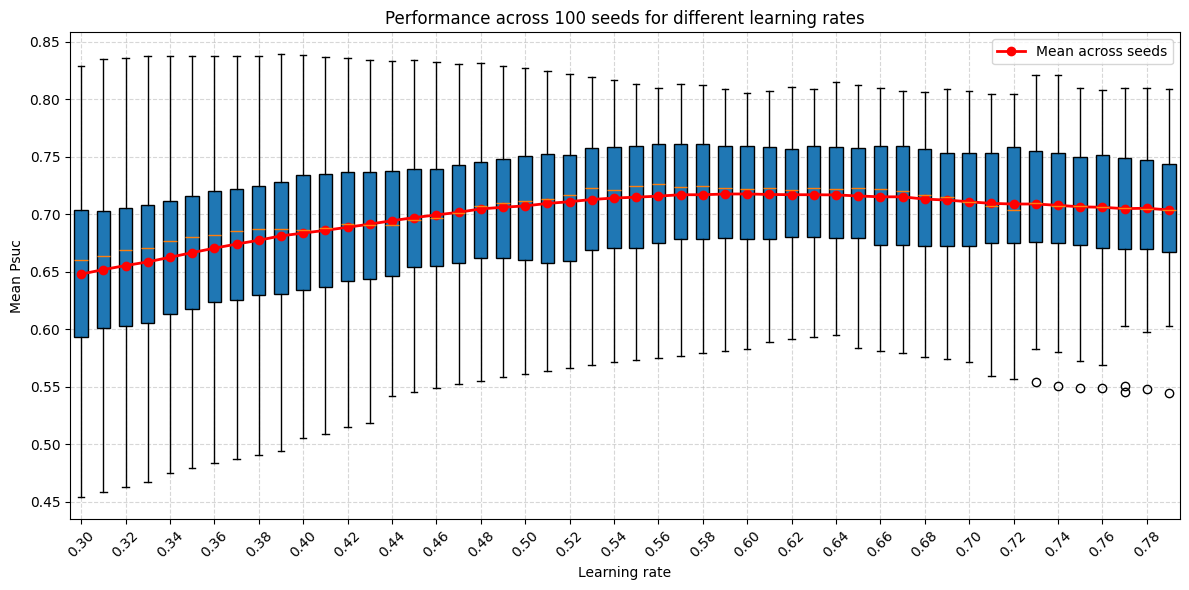

Best learning rate: 0.60 with mean Psuc = 0.7177


In [137]:
opt_lr_1s_s1 = compute_optimal_lr(all_mean_Psucs, lr_values=lr_values, num_seeds=len(seeds))

In [138]:
### Let's try the optimal lr in a few exps!

In [139]:
# SETUP PARAMETER

lr_values = [opt_lr_1s_s1]
seeds = np.arange(0, 100)

In [140]:
all_mean_Psucs_1s_s1, all_min_Psucs_1s_s1 = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 5
 - Sigma: (1.0, 1.0)
 - Shots: 1
 - lr: [np.float64(0.6)]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


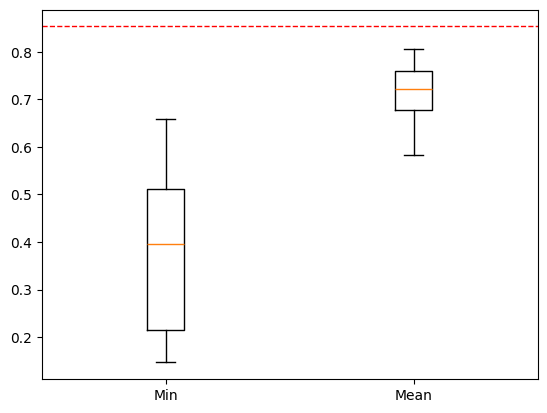

In [141]:
plt.boxplot([all_min_Psucs_1s_s1.flatten(), all_mean_Psucs_1s_s1.flatten()], tick_labels=["Min", "Mean"])
plt.axhline(y=0.8536, color='r', linestyle='--', linewidth=1)
plt.show()

### Single client ¡10 shots!

In [142]:
n_shots = 10

In [143]:
# SETUP PARAMETER

lr_values = np.arange(0.30, 0.80, 0.01)
seeds = np.arange(0, 100)

In [144]:
all_mean_Psucs, all_min_Psucs = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 5
 - Sigma: (1.0, 1.0)
 - Shots: 10
 - lr: [0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41 0.42 0.43
 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55 0.56 0.57
 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69 0.7  0.71
 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


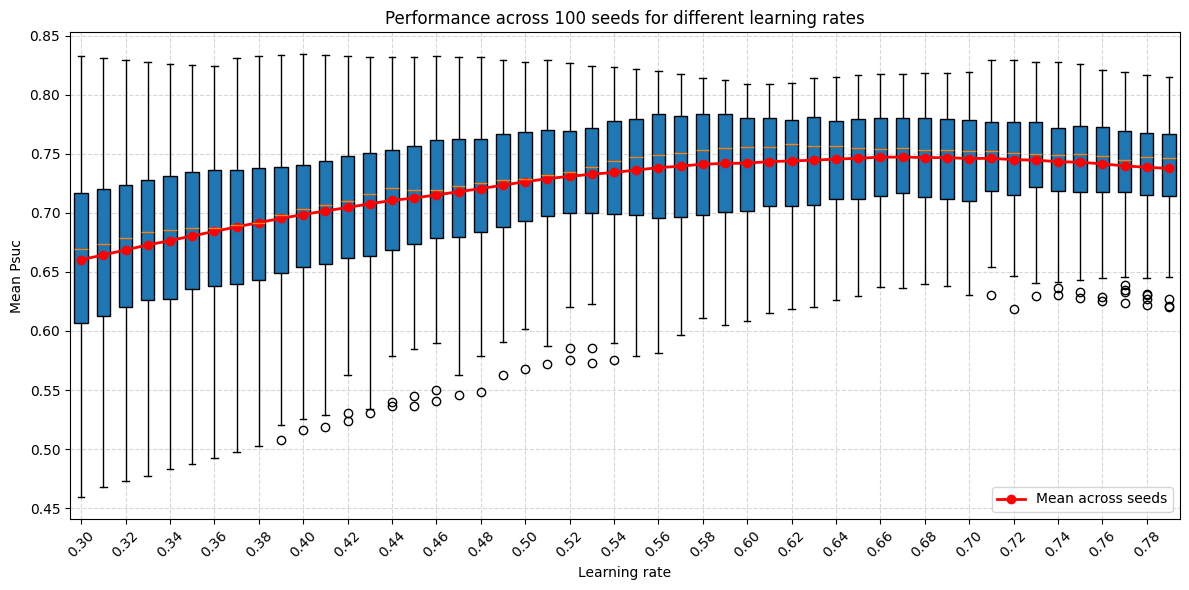

Best learning rate: 0.67 with mean Psuc = 0.7472


In [145]:
opt_lr_10s_s1 = compute_optimal_lr(all_mean_Psucs, lr_values=lr_values, num_seeds=len(seeds))

In [146]:
# SETUP PARAMETER

lr_values = [opt_lr_10s_s1]
seeds = np.arange(0, 100)

In [147]:
all_mean_Psucs_10s_s1, all_min_Psucs_10s_s1 = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 5
 - Sigma: (1.0, 1.0)
 - Shots: 10
 - lr: [np.float64(0.67)]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


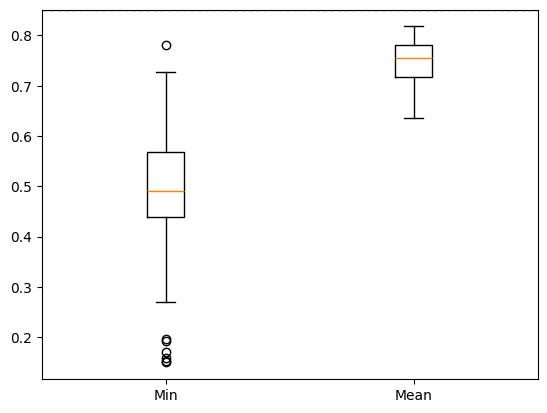

In [148]:
plt.boxplot([all_min_Psucs_10s_s1.flatten(), all_mean_Psucs_10s_s1.flatten()], tick_labels=["Min", "Mean"])
plt.axhline(y=0.85, color='r', linestyle='--', linewidth=1)
plt.show()

### Single client ¡100 shots!

In [149]:
n_shots = 100

In [150]:
# SETUP PARAMETER

lr_values = np.arange(0.30, 0.80, 0.01)
seeds = np.arange(0, 100)

In [151]:
all_mean_Psucs, all_min_Psucs = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 5
 - Sigma: (1.0, 1.0)
 - Shots: 100
 - lr: [0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41 0.42 0.43
 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55 0.56 0.57
 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69 0.7  0.71
 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


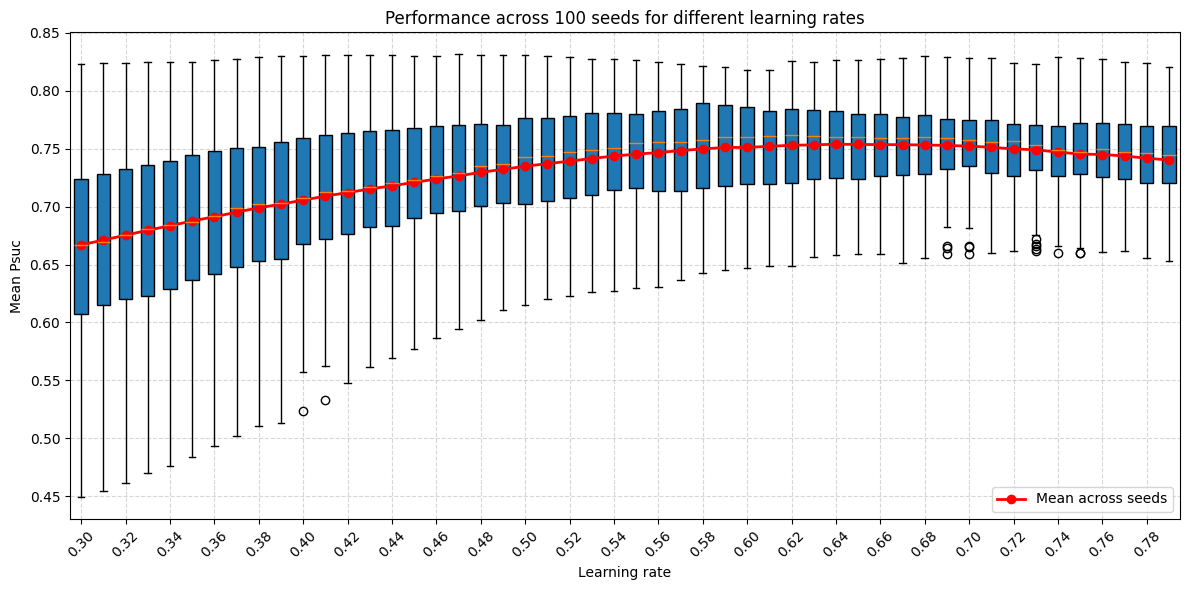

Best learning rate: 0.64 with mean Psuc = 0.7539


In [152]:
opt_lr_100s_s1 = compute_optimal_lr(all_mean_Psucs, lr_values=lr_values, num_seeds=len(seeds))

In [153]:
# SETUP PARAMETER

lr_values = [opt_lr_100s_s1]
seeds = np.arange(0, 100)

In [154]:
all_mean_Psucs_100s_s1, all_min_Psucs_100s_s1 = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 5
 - Sigma: (1.0, 1.0)
 - Shots: 100
 - lr: [np.float64(0.64)]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


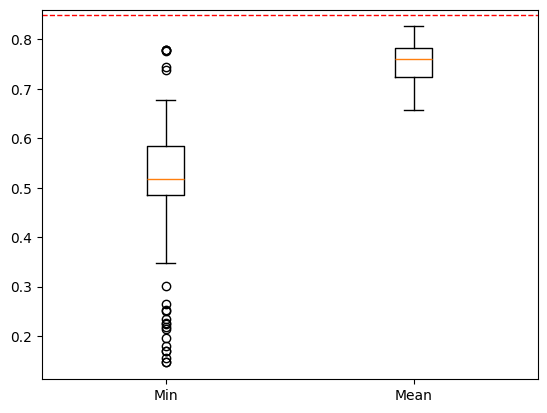

In [155]:
plt.boxplot([all_min_Psucs_100s_s1.flatten(), all_mean_Psucs_100s_s1.flatten()], tick_labels=["Min", "Mean"])
plt.axhline(y=0.85, color='r', linestyle='--', linewidth=1)
plt.show()

### QFL - 1 round with 5 local updates

In [156]:
# SETUP PARAMETER
num_rounds = 1
local_batch_size = 5
n_shots = 1

lr_values = np.arange(0.1, 1.1, 0.01)
seeds = np.arange(0, 100)

In [157]:
QFL_Psucs = repeat_ECAI_QFL_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots,
    num_rounds = num_rounds,
    local_batch_size = local_batch_size
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 5
 - Sigma: (1.0, 1.0)
 - Shots: 1
 - Number of Rounds: 1
 - Local Batch: 5
 - lr: [0.1  0.11 0.12 0.13 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23
 0.24 0.25 0.26 0.27 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37
 0.38 0.39 0.4  0.41 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51
 0.52 0.53 0.54 0.55 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65
 0.66 0.67 0.68 0.69 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79
 0.8  0.81 0.82 0.83 0.84 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93
 0.94 0.95 0.96 0.97 0.98 0.99 1.   1.01 1.02 1.03 1.04 1.05 1.06 1.07
 1.08 1.09]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


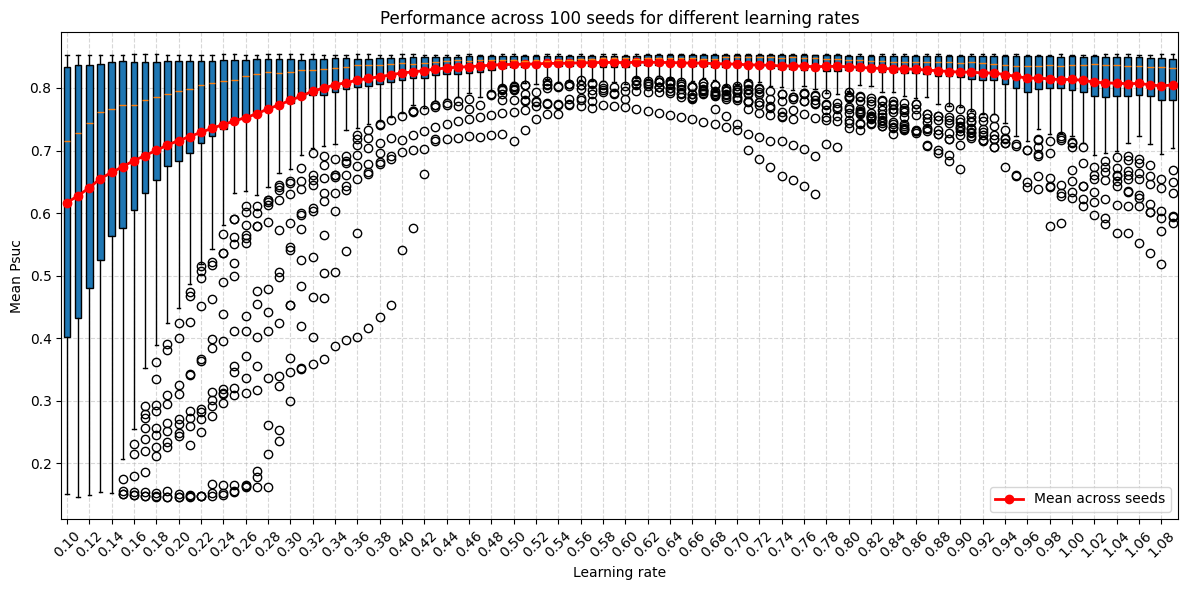

Best learning rate: 0.62 with mean Psuc = 0.8412


In [158]:
opt_lr_qfl_s1 = compute_optimal_lr(QFL_Psucs, lr_values=lr_values, num_seeds=len(seeds))

In [159]:
# SETUP PARAMETER
num_rounds = 1
local_batch_size = 5

lr_values = [opt_lr_qfl_s1]
seeds = np.arange(0, 100)

n_shots = 1

In [160]:
QFL_Psucs_s1 = repeat_ECAI_QFL_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots,
    num_rounds = num_rounds,
    local_batch_size = local_batch_size
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 5
 - Sigma: (1.0, 1.0)
 - Shots: 1
 - Number of Rounds: 1
 - Local Batch: 5
 - lr: [np.float64(0.62)]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


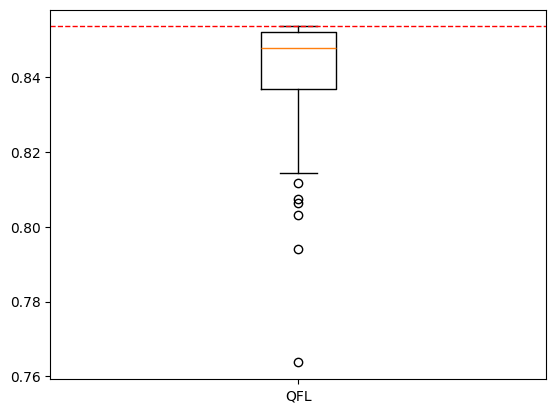

In [161]:
plt.boxplot([QFL_Psucs_s1.flatten()], tick_labels=["QFL"])
plt.axhline(y=0.8536, color='r', linestyle='--', linewidth=1)
plt.show()

### Comparisons

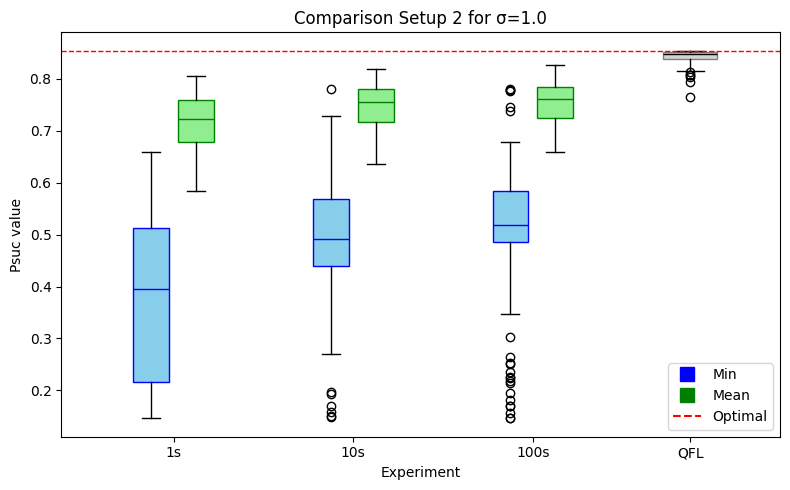

In [162]:
# Your data
min_setup1 = [all_min_Psucs_1s_s1.flatten(),
              all_min_Psucs_10s_s1.flatten(),
              all_min_Psucs_100s_s1.flatten()]

mean_setup1 = [all_mean_Psucs_1s_s1.flatten(),
               all_mean_Psucs_10s_s1.flatten(),
               all_mean_Psucs_100s_s1.flatten()]

QFL = QFL_Psucs_s1.flatten()

# Define positions
positions_min = [1, 2, 3]
positions_mean = [p + 0.25 for p in positions_min]
position_QFL = [4]

plt.figure(figsize=(8, 5))

# Box colors
boxprops_min = dict(facecolor='skyblue', color='blue')
boxprops_mean = dict(facecolor='lightgreen', color='green')
boxprops_qfl = dict(facecolor='lightgray', color='gray')

# Plot boxplots
plt.boxplot(min_setup1, positions=positions_min, widths=0.2, patch_artist=True,
            boxprops=boxprops_min, medianprops=dict(color='blue'))
plt.boxplot(mean_setup1, positions=positions_mean, widths=0.2, patch_artist=True,
            boxprops=boxprops_mean, medianprops=dict(color='green'))
plt.boxplot([QFL], positions=position_QFL, widths=0.3, patch_artist=True,
            boxprops=boxprops_qfl, medianprops=dict(color='black'))

# Reference line
plt.axhline(y=0.8536, color='r', linestyle='--', linewidth=1, label="Reference (0.8536)")

# X-axis labels
xticks = [p + 0.125 for p in positions_min] + position_QFL
xticklabels = ["1s", "10s", "100s", "QFL"]
plt.xticks(xticks, xticklabels)

plt.xlabel("Experiment")
plt.ylabel("Psuc value")
plt.title(f"Comparison Setup 2 for σ={sigma_range[0]}")

# Legend — only Min, Mean, and Reference
handles = [
    plt.Line2D([], [], color='blue', marker='s', markersize=10, linestyle='None', label='Min'),
    plt.Line2D([], [], color='green', marker='s', markersize=10, linestyle='None', label='Mean'),
    plt.Line2D([], [], color='red', linestyle='--', label='Optimal')
]
plt.legend(handles=handles, loc='best')

plt.tight_layout()
plt.show()


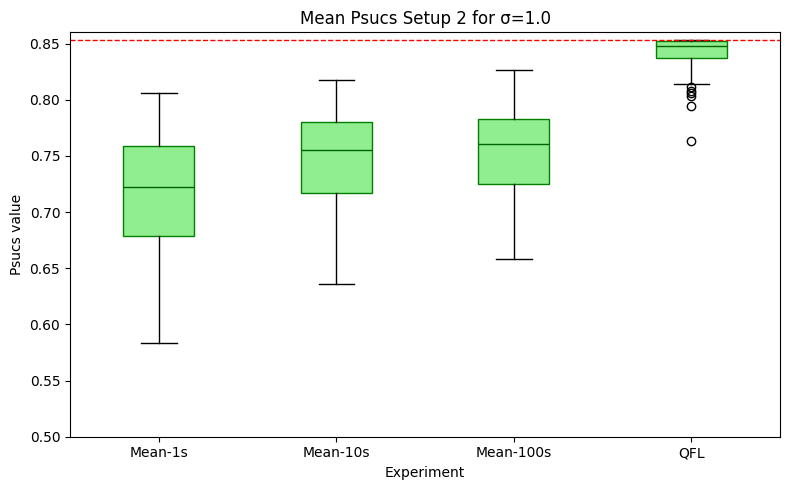

In [163]:
# Your data (mean only)
mean_setup1 = [all_mean_Psucs_1s_s1.flatten(),
               all_mean_Psucs_10s_s1.flatten(),
               all_mean_Psucs_100s_s1.flatten(),
               QFL_Psucs_s1.flatten()]

# Create figure
plt.figure(figsize=(8, 5))

# Box color settings
boxprops_mean = dict(facecolor='lightgreen', color='green')

# Plot boxplot
plt.boxplot(mean_setup1, tick_labels=["Mean-1s", "Mean-10s", "Mean-100s", "QFL"],
            widths=0.4, patch_artist=True,
            boxprops=boxprops_mean, medianprops=dict(color='darkgreen'))

# Reference line
plt.axhline(y=0.8536, color='r', linestyle='--', linewidth=1)

# Labels and title
plt.xlabel("Experiment")
plt.ylabel("Psucs value")
plt.title(f"Mean Psucs Setup 2 for σ={sigma_range[0]}")

# Optionally zoom in on higher range (adjust as needed)
plt.ylim(0.5, 0.86)  # <-- Adjust this range depending on your data

plt.tight_layout()
plt.show()


In [164]:
print(np.mean(all_min_Psucs_1s_s1))
print(np.mean(all_min_Psucs_10s_s1))
print(np.mean(all_min_Psucs_100s_s1))
print(np.mean(QFL_Psucs_s1))

0.376203
0.493073
0.500084
0.8411930000000001


In [165]:
print(np.mean(all_mean_Psucs_1s_s1))
print(np.mean(all_mean_Psucs_10s_s1))
print(np.mean(all_mean_Psucs_100s_s1))
print(np.mean(QFL_Psucs_s1))

0.7177200999999997
0.7471542000000001
0.7538820000000002
0.8411930000000001


In [166]:
print(np.max(all_mean_Psucs_100s_s1))
print(np.max(QFL_Psucs_s1))

0.82621
0.8536


## σ=4.0

In [167]:
sigma_range = (4.0, 4.0)

### Single client 1 shot

In [168]:
n_shots = 1

In [169]:
# SETUP PARAMETER

lr_values = np.arange(0.30, 0.80, 0.01)
seeds = np.arange(0, 100)

In [170]:
all_mean_Psucs, all_min_Psucs = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 5
 - Sigma: (4.0, 4.0)
 - Shots: 1
 - lr: [0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41 0.42 0.43
 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55 0.56 0.57
 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69 0.7  0.71
 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


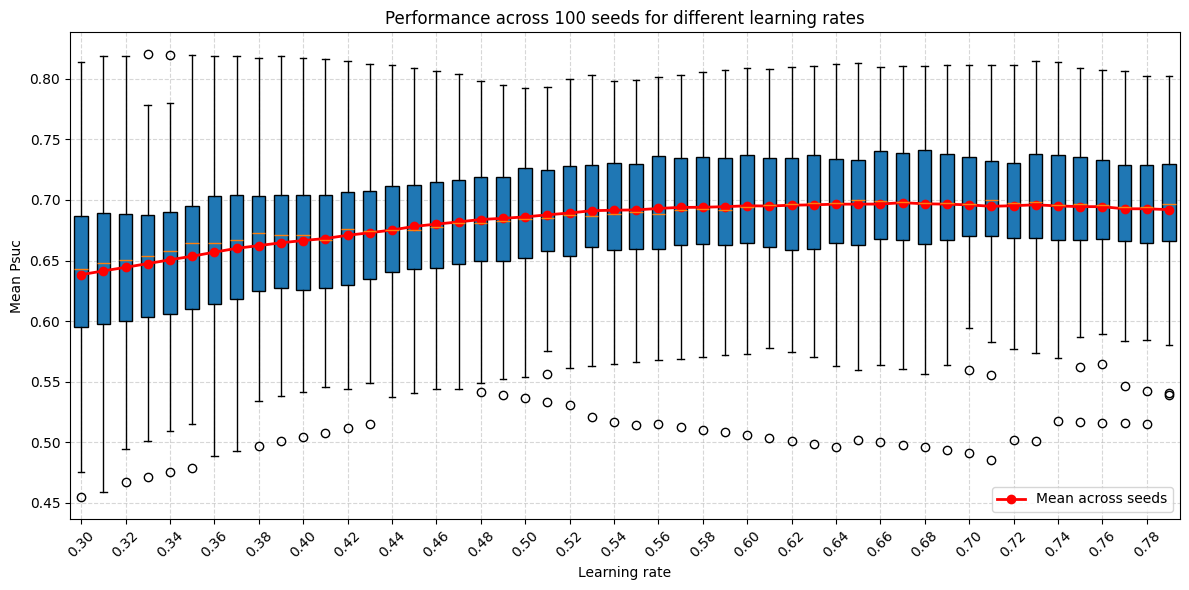

Best learning rate: 0.67 with mean Psuc = 0.6978


In [171]:
opt_lr_1s_s4 = compute_optimal_lr(all_mean_Psucs, lr_values=lr_values, num_seeds=len(seeds))

In [172]:
### Let's try the optimal lr in a few exps!

In [173]:
# SETUP PARAMETER

lr_values = [opt_lr_1s_s4]
seeds = np.arange(0, 100)

In [174]:
all_mean_Psucs_1s_s4, all_min_Psucs_1s_s4 = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 5
 - Sigma: (4.0, 4.0)
 - Shots: 1
 - lr: [np.float64(0.67)]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


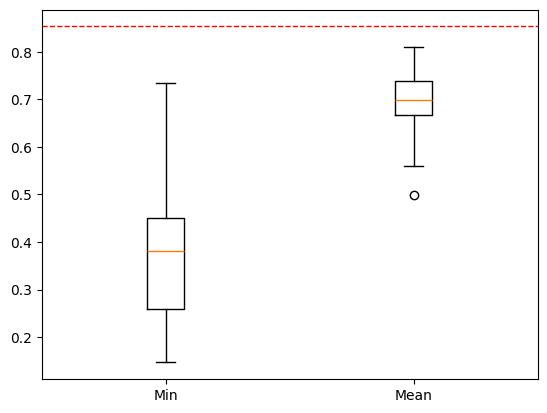

In [175]:
plt.boxplot([all_min_Psucs_1s_s4.flatten(), all_mean_Psucs_1s_s4.flatten()], tick_labels=["Min", "Mean"])
plt.axhline(y=0.8536, color='r', linestyle='--', linewidth=1)
plt.show()

### Single client ¡10 shots!

In [176]:
n_shots = 10

In [177]:
# SETUP PARAMETER

lr_values = np.arange(0.30, 0.80, 0.01)
seeds = np.arange(0, 100)

In [178]:
all_mean_Psucs, all_min_Psucs = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 5
 - Sigma: (4.0, 4.0)
 - Shots: 10
 - lr: [0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41 0.42 0.43
 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55 0.56 0.57
 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69 0.7  0.71
 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


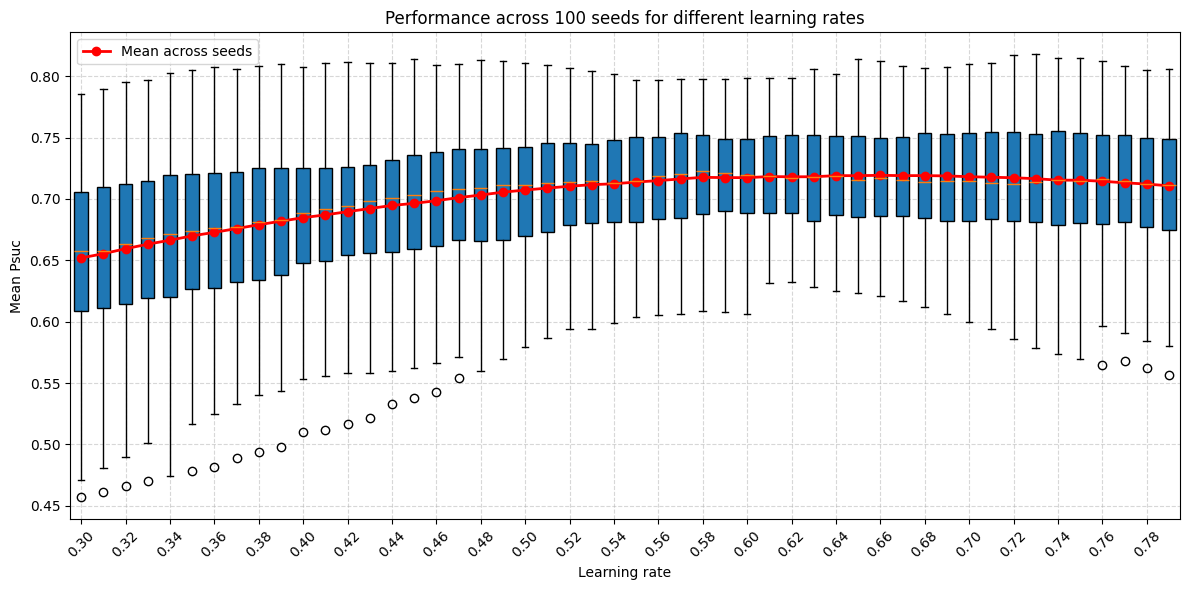

Best learning rate: 0.66 with mean Psuc = 0.7193


In [179]:
opt_lr_10s_s4 = compute_optimal_lr(all_mean_Psucs, lr_values=lr_values, num_seeds=len(seeds))

In [180]:
# SETUP PARAMETER

lr_values = [opt_lr_10s_s4]
seeds = np.arange(0, 100)

In [181]:
all_mean_Psucs_10s_s4, all_min_Psucs_10s_s4 = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 5
 - Sigma: (4.0, 4.0)
 - Shots: 10
 - lr: [np.float64(0.66)]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


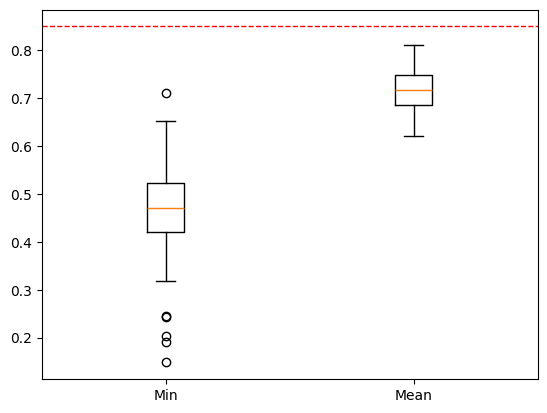

In [182]:
plt.boxplot([all_min_Psucs_10s_s4.flatten(), all_mean_Psucs_10s_s4.flatten()], tick_labels=["Min", "Mean"])
plt.axhline(y=0.85, color='r', linestyle='--', linewidth=1)
plt.show()

### Single client ¡100 shots!

In [183]:
n_shots = 100

In [184]:
# SETUP PARAMETER

lr_values = np.arange(0.30, 0.80, 0.01)
seeds = np.arange(0, 100)

In [185]:
all_mean_Psucs, all_min_Psucs = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 5
 - Sigma: (4.0, 4.0)
 - Shots: 100
 - lr: [0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41 0.42 0.43
 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55 0.56 0.57
 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69 0.7  0.71
 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


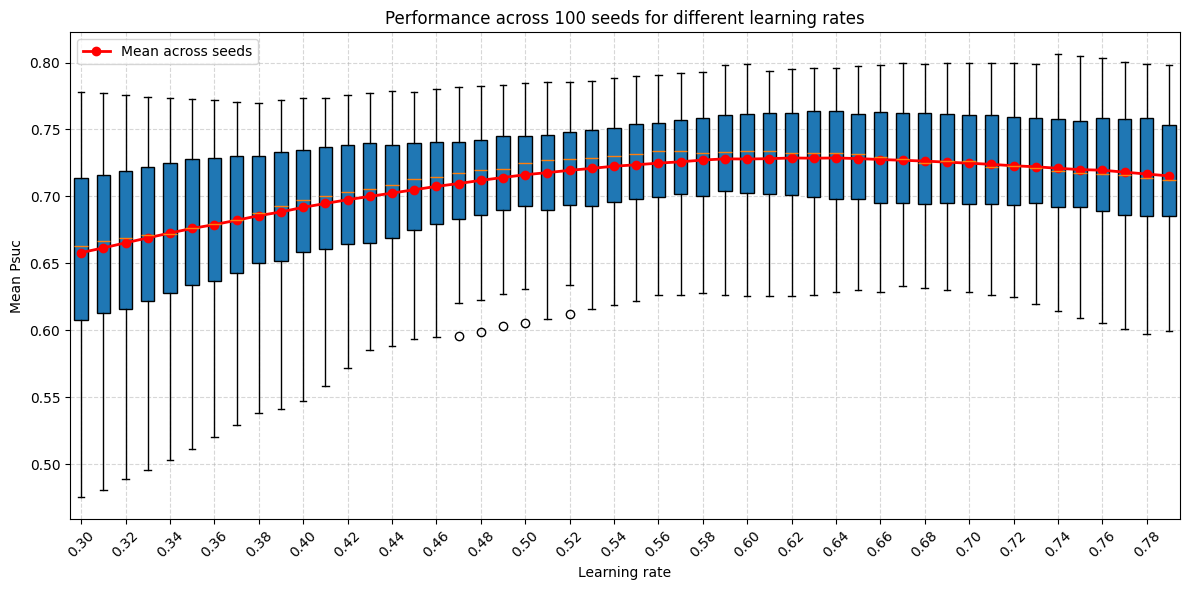

Best learning rate: 0.64 with mean Psuc = 0.7287


In [186]:
opt_lr_100s_s4 = compute_optimal_lr(all_mean_Psucs, lr_values=lr_values, num_seeds=len(seeds))

In [187]:
# SETUP PARAMETER

lr_values = [opt_lr_100s_s4]
seeds = np.arange(0, 100)

In [188]:
all_mean_Psucs_100s_s4, all_min_Psucs_100s_s4 = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 5
 - Sigma: (4.0, 4.0)
 - Shots: 100
 - lr: [np.float64(0.64)]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


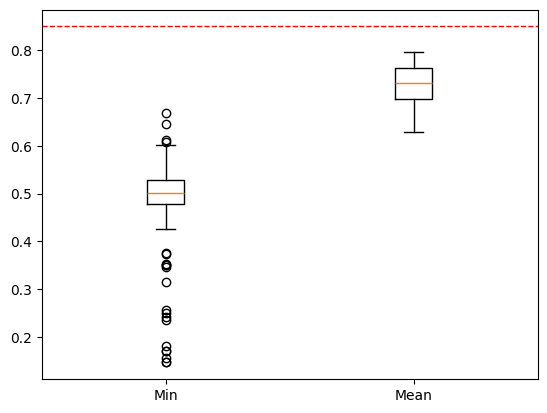

In [189]:
plt.boxplot([all_min_Psucs_100s_s4.flatten(), all_mean_Psucs_100s_s4.flatten()], tick_labels=["Min", "Mean"])
plt.axhline(y=0.85, color='r', linestyle='--', linewidth=1)
plt.show()

### QFL - 1 round wit 5 local updates

In [190]:
# SETUP PARAMETER
num_rounds = 1
local_batch_size = 5
n_shots = 1

lr_values = np.arange(0.1, 1.1, 0.01)
seeds = np.arange(0, 100)

In [191]:
QFL_Psucs = repeat_ECAI_QFL_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots,
    num_rounds = num_rounds,
    local_batch_size = local_batch_size
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 5
 - Sigma: (4.0, 4.0)
 - Shots: 1
 - Number of Rounds: 1
 - Local Batch: 5
 - lr: [0.1  0.11 0.12 0.13 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23
 0.24 0.25 0.26 0.27 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37
 0.38 0.39 0.4  0.41 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51
 0.52 0.53 0.54 0.55 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65
 0.66 0.67 0.68 0.69 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79
 0.8  0.81 0.82 0.83 0.84 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93
 0.94 0.95 0.96 0.97 0.98 0.99 1.   1.01 1.02 1.03 1.04 1.05 1.06 1.07
 1.08 1.09]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


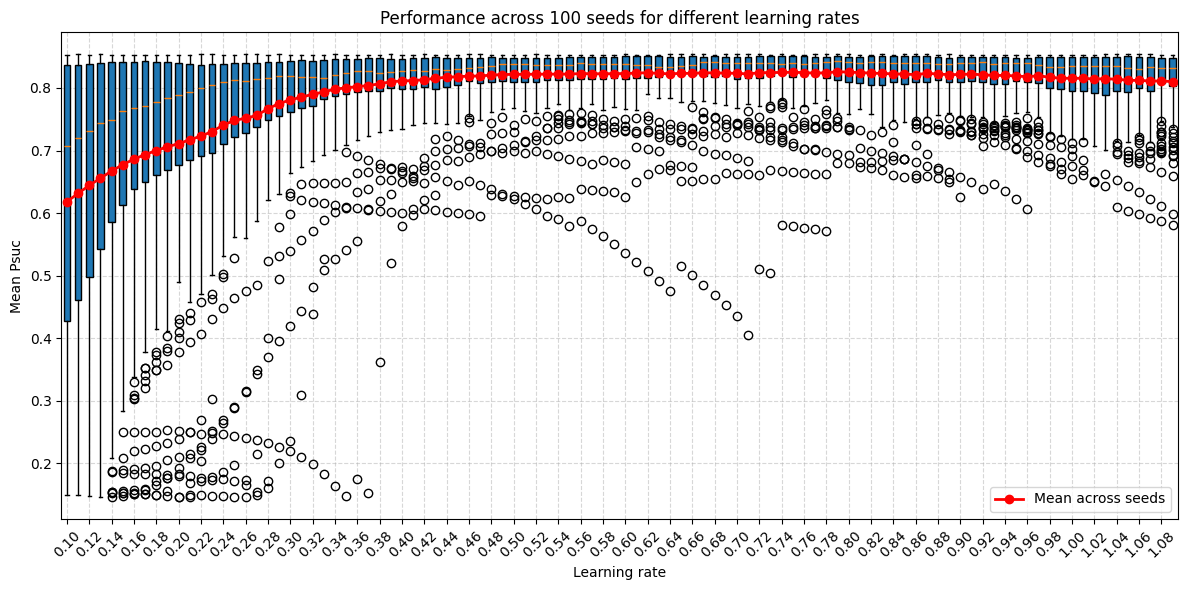

Best learning rate: 0.79 with mean Psuc = 0.8261


In [192]:
opt_lr_qfl_s4 = compute_optimal_lr(QFL_Psucs, lr_values=lr_values, num_seeds=len(seeds))

In [193]:
# SETUP PARAMETER
num_rounds = 1
local_batch_size = 5

lr_values = [opt_lr_qfl_s4]
seeds = np.arange(0, 100)

n_shots = 1

In [194]:
QFL_Psucs_s4 = repeat_ECAI_QFL_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots,
    num_rounds = num_rounds,
    local_batch_size = local_batch_size
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 5
 - Sigma: (4.0, 4.0)
 - Shots: 1
 - Number of Rounds: 1
 - Local Batch: 5
 - lr: [np.float64(0.79)]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


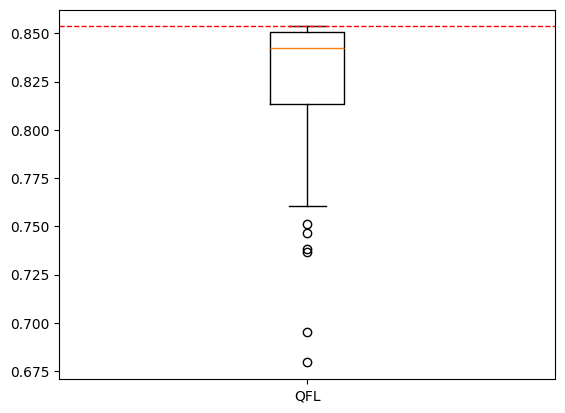

In [195]:
plt.boxplot([QFL_Psucs_s4.flatten()], tick_labels=["QFL"])
plt.axhline(y=0.8536, color='r', linestyle='--', linewidth=1)
plt.show()

### Comparisons

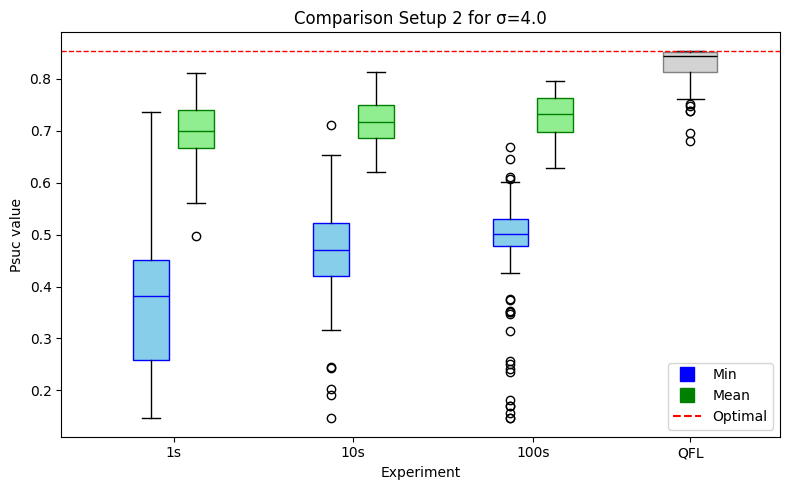

In [196]:
# Your data
min_setup1 = [all_min_Psucs_1s_s4.flatten(),
              all_min_Psucs_10s_s4.flatten(),
              all_min_Psucs_100s_s4.flatten()]

mean_setup1 = [all_mean_Psucs_1s_s4.flatten(),
               all_mean_Psucs_10s_s4.flatten(),
               all_mean_Psucs_100s_s4.flatten()]

QFL = QFL_Psucs_s4.flatten()

# Define positions
positions_min = [1, 2, 3]
positions_mean = [p + 0.25 for p in positions_min]
position_QFL = [4]

plt.figure(figsize=(8, 5))

# Box colors
boxprops_min = dict(facecolor='skyblue', color='blue')
boxprops_mean = dict(facecolor='lightgreen', color='green')
boxprops_qfl = dict(facecolor='lightgray', color='gray')

# Plot boxplots
plt.boxplot(min_setup1, positions=positions_min, widths=0.2, patch_artist=True,
            boxprops=boxprops_min, medianprops=dict(color='blue'))
plt.boxplot(mean_setup1, positions=positions_mean, widths=0.2, patch_artist=True,
            boxprops=boxprops_mean, medianprops=dict(color='green'))
plt.boxplot([QFL], positions=position_QFL, widths=0.3, patch_artist=True,
            boxprops=boxprops_qfl, medianprops=dict(color='black'))

# Reference line
plt.axhline(y=0.8536, color='r', linestyle='--', linewidth=1, label="Reference (0.8536)")

# X-axis labels
xticks = [p + 0.125 for p in positions_min] + position_QFL
xticklabels = ["1s", "10s", "100s", "QFL"]
plt.xticks(xticks, xticklabels)

plt.xlabel("Experiment")
plt.ylabel("Psuc value")
plt.title(f"Comparison Setup 2 for σ={sigma_range[0]}")

# Legend — only Min, Mean, and Reference
handles = [
    plt.Line2D([], [], color='blue', marker='s', markersize=10, linestyle='None', label='Min'),
    plt.Line2D([], [], color='green', marker='s', markersize=10, linestyle='None', label='Mean'),
    plt.Line2D([], [], color='red', linestyle='--', label='Optimal')
]
plt.legend(handles=handles, loc='best')

plt.tight_layout()
plt.show()


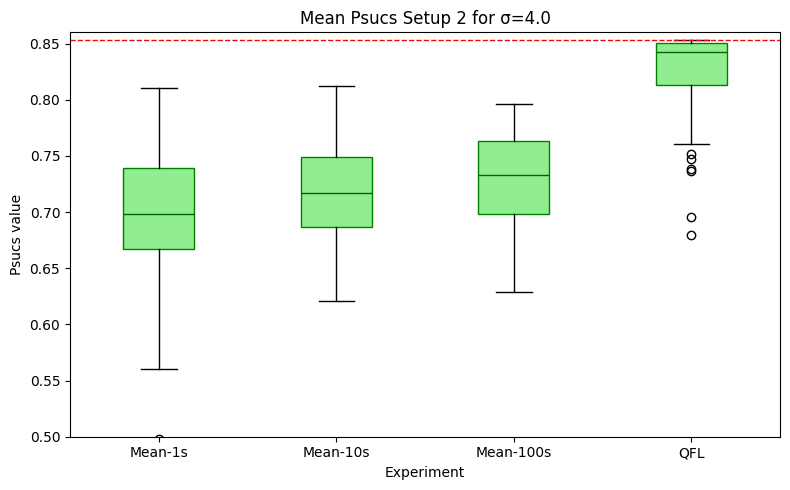

In [197]:
# Your data (mean only)
mean_setup1 = [all_mean_Psucs_1s_s4.flatten(),
               all_mean_Psucs_10s_s4.flatten(),
               all_mean_Psucs_100s_s4.flatten(),
               QFL_Psucs_s4.flatten()]

# Create figure
plt.figure(figsize=(8, 5))

# Box color settings
boxprops_mean = dict(facecolor='lightgreen', color='green')

# Plot boxplot
plt.boxplot(mean_setup1, tick_labels=["Mean-1s", "Mean-10s", "Mean-100s", "QFL"],
            widths=0.4, patch_artist=True,
            boxprops=boxprops_mean, medianprops=dict(color='darkgreen'))

# Reference line
plt.axhline(y=0.8536, color='r', linestyle='--', linewidth=1)

# Labels and title
plt.xlabel("Experiment")
plt.ylabel("Psucs value")
plt.title(f"Mean Psucs Setup 2 for σ={sigma_range[0]}")

# Optionally zoom in on higher range (adjust as needed)
plt.ylim(0.5, 0.86)  # <-- Adjust this range depending on your data

plt.tight_layout()
plt.show()


In [198]:
print(np.mean(all_min_Psucs_1s_s4))
print(np.mean(all_min_Psucs_10s_s4))
print(np.mean(all_min_Psucs_100s_s4))
print(np.mean(QFL_Psucs_s4))

0.36388400000000004
0.4671429999999999
0.475604
0.8260870000000001


In [199]:
print(np.mean(all_mean_Psucs_1s_s4))
print(np.mean(all_mean_Psucs_10s_s4))
print(np.mean(all_mean_Psucs_100s_s4))
print(np.mean(QFL_Psucs_s4))

0.6977535
0.7192647000000002
0.7287259999999999
0.8260870000000001


In [200]:
print(np.max(all_mean_Psucs_100s_s4))
print(np.max(QFL_Psucs_s4))

0.79625
0.8536
